In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, random, pickle, os
from datetime import datetime, timedelta
from matplotlib import ticker
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display, clear_output
from google.colab import drive
drive.mount('/content/drive')

DIR = '/content/drive/MyDrive/Colab Notebooks/Машинное обучение/dynamic_price/project/data/'
# DIR = os.getcwd() + '/data/'
TRANSACTIONS = 'transactions.csv'    # данные о транзакциях пользователей
SAMPLE_SKU = 'sample_1000.csv'       # выборка из 1000 SKU
PROMO = 'promo_df.csv'               # данные о промоакциях
CANC_PRICE = 'canc_df.csv'           # данные о ценах конкурентов
SALES_PLAN = 'sales_plan.csv'        # данные о планах продаж
TRADES = 'wholesale_trade_table.csv' # данные по закупкам

!pip install tslearn
# !pip install prophet
# !pip install catboost
clear_output()

QUANTILE = [0.05, 0.5, 0.95]
PANDAS_DATE_FORMAT = '%Y-%m-%d'

In [2]:
# russian holidays calendar
RU_holidays = {
 "New Year's Day (Новый год)" : '12-31',
 "Orthodox Christmas Day (Рождество Христово)" : '01-07',
 "Defender of the Fatherland Day (День защитника Отечества)" :'02-23',
 "International Women's Day (Международный женский день)":'03-08',
 "Spring and Labor Day":'05-01',
 "Victory Day (День Победы)":'05-09',
 "Russia Day (День России)":'06-12',
 "Unity Day (День народного единства)":'11-4',
 "День знаний": '09-01',
 "День Святого Валентина":'02-14',
 "Black Friday" : '11-29',
}
years = ['2018', '2019']
df_holidays = pd.DataFrame()
for key in RU_holidays.keys():
  _ = pd.DataFrame(
      {
          'ds': [y + '-' + RU_holidays[key] for y in years],
          'holiday': key
      }
  )
  df_holidays = pd.concat([df_holidays, _])
df_holidays = (df_holidays.assign(ds = lambda x: pd.to_datetime(x['ds']))
                          .assign(year = lambda x: x['ds'].dt.year)
                          .assign(week_num =  lambda x: x['ds'].dt.isocalendar().week)
                          .assign(year_week =  lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                          .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                          )

In [3]:
# clustering result
clusters = (pd.concat([pd.read_csv(DIR + 'class_10.csv'),
                       pd.read_csv(DIR + 'class_50.csv'),
                       pd.read_csv(DIR + 'class_100.csv'),
                       pd.read_csv(DIR + 'class_200.csv'),
                       pd.read_csv(DIR + 'class_300.csv'),
                       pd.read_csv(DIR + 'class_400.csv'),
                       pd.read_csv(DIR + 'class_400_DWT.csv'),
                       pd.read_csv(DIR + 'class_50_DWT.csv'),
                       pd.read_csv(DIR + 'class_200_DWT.csv'),
                      ]).query("`class` != -1")
                        .assign(sku_group = lambda x: x['interval'].astype(str) + '_' + x['class'].astype(str))
                        [['SKU', 'sku_group']])

In [4]:
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
colors = list(mcolors.XKCD_COLORS.keys())
SKUs = clusters['sku_group'].unique()
# define color for each cluster
palette = {SKUs[i] : colors[i] for i in range(0, SKUs.shape[0])}

In [5]:
import statsmodels.api as sm
# from catboost import CatBoostRegressor
# from sklearn.linear_model import ElasticNet
from sklearn.linear_model import QuantileRegressor

class QuantileRegressionModel:
    def __init__(self, quantiles=[0.25, 0.5, 0.75]):
        self.quantiles = quantiles
        self.models = {'pred_q' + str(int(q*100)): QuantileRegressor(quantile=q) for q in quantiles}

    def fit(self, X, y):
        for q, model in self.models.items():
            model.fit(X, y)
        return self

    def predict(self, X):
        predictions = {}
        for q, model in self.models.items():
            predictions[q] = model.predict(X)
        return predictions
# add functions to build regression models for each SKU
# regression describe dependence of num_purchase and price per SKU
def transform(x) -> np.array:
  # add non-linear features based on x - num_purchase, log(x), x^2, x^0.5
  # suppose that dependence is non - linear
  if type(x) == pd.DataFrame:
    x = x.to_numpy().reshape(-1, 1)
  else:
    x = np.array(x).reshape(-1, 1)
  x_square = x ** 2
  x_log = np.log2(x)
  x_root = x ** 0.5

  X = np.concatenate((x,
                      x_square,
                      x_log,
                      x_root
                      ), axis = 1)
  return X

def build_regression(data:pd.DataFrame, x_col: str, y_col: str, SKU: int, quantiles:list):
  # use OLS model to find regression coeff
  x = data.query("SKU.isin([@SKU])")[x_col]
  y = data.query("SKU.isin([@SKU])")[y_col]
  X = transform(x)
  # regress = sm.OLS(y, X).fit()
  # regress = ElasticNet(alpha=0.5, l1_ratio= 0.7).fit(X, y)
  regress = QuantileRegressionModel(quantiles).fit(X, y)
  # regress = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=3, verbose=False, allow_const_label=True, l2_leaf_reg = 10).fit(X,y)
  return regress

def use_regression(x_min:float, x_max: float, regress) -> tuple:
  # use regression for plotting
  x_range = range(int(x_min), int(x_max) + 1)
  y = lambda x: regress.predict(transform(x))
  return x_range, y(x_range)

In [6]:
# define LSTM quantile model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch, torch.nn as nn

from shapely.geometry import Polygon, box, LineString
from matplotlib.patches import Polygon as MplPolygon
from shapely.ops import cascaded_union, unary_union

# quantile regression metric intersection over union
def calculate_iou(lower, upper, target, std, plot_polygons = False):
    # calculate intersection over union
    def create_polygon(y1, y2):
      if y1.shape != y2.shape:
          raise ValueError("Массивы y-координат должны иметь одинаковую длину.")
      x = np.arange(len(y1))

      points = np.vstack((np.column_stack((x, y1)), np.column_stack((x[::-1], y2[::-1]))))
      polygon = Polygon(points)
      return polygon

    def calculate_intersection_area(polygon1, polygon2):
        # calculate intersaction
        intersection = polygon1.intersection(polygon2)
        return intersection.area

    def calculate_union_area(*lines):
        # this manual union to consider all area between max line and min line union polygon
        lower_union = pd.concat(list(lines), axis = 1).min(axis = 1)
        upper_union = pd.concat(list(lines), axis = 1).max(axis = 1)
        union = create_polygon(lower_union, upper_union)

        return union.area
    # remove indexes
    lower = lower.reset_index(drop = True)
    upper = upper.reset_index(drop = True)
    target = target.reset_index(drop = True)
    # create polygons to calculate intersactions
    polygon1 = create_polygon(lower, upper)
    polygon2 = create_polygon(target - std, target + std)
    # plot if necessary
    if plot_polygons:
      plt.figure(figsize=(2, 2))
      x,y = polygon1.exterior.xy
      plt.plot(x,y)
      x,y = polygon2.exterior.xy
      plt.plot(x,y)
      plt.show()

    intersection = calculate_intersection_area(polygon1, polygon2)
    union = calculate_union_area(target - std, target + std, lower, upper)

    return intersection / union
# loss function
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = torch.tensor(quantiles)

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        quantiles_minus_1 = self.quantiles - 1
        errors = target.unsqueeze(1) - preds
        losses = torch.max(quantiles_minus_1 * errors, self.quantiles * errors)
        loss = torch.mean(torch.sum(losses, dim=1))
        return loss
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1].unsqueeze(0)
# define class SKU_LSTM to build LSTM model for each of SKU
class SKU_LSTM_quantille():
  def __init__(self,
               raw_data,
               SKU,
               SKU_lag_assumptions = 5,
               epochs = 100,
               lr=0.001,
               value = 'num_purchase',
               quantiles = [0.25, 0.5, 0.75],
               seed = 42
               ):

    self.seed_everything(seed)
    self.SKU = SKU
    self.value = value
    self.df_train = raw_data.query("SKU.isin([@SKU])")
    self.scaler = StandardScaler()
    self.train_data_norm = self.scale_transform(self.df_train)
    self.quantiles = quantiles

    self.train_window = int(SKU_lag_assumptions) # try to get more wide window
    self.train_inout_seq = self.create_inout_sequences(self.train_data_norm, self.train_window)
    self.epochs = epochs

    self.model = LSTM(output_size = len(self.quantiles))
    self.loss_function = QuantileLoss(self.quantiles)
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr = lr)

  def seed_everything(self, seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  # scaling and casting to tourch tensor
  def scale_transform(self, df):
    _ = self.scaler.fit_transform(df[self.value].to_numpy().reshape(-1,1))
    _ = torch.FloatTensor(_).view(-1)
    return _

  # The function will accept the raw input data and will return a list of tuples.
  # In each tuple, the first element will contain a list of N items corresponding to the number of num purchase in N days,
  # the second tuple element will contain one item i.e. the number of purchase in the N+1st days. N = train_window
  def create_inout_sequences(self, input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

  def fit(self):
    for i in range(self.epochs):
      for seq, labels in self.train_inout_seq:
        self.optimizer.zero_grad()
        self.model.hidden_cell = (torch.zeros(1, 1, self.model.hidden_layer_size),
                                  torch.zeros(1, 1, self.model.hidden_layer_size))
        y_pred = self.model(seq)

        single_loss = self.loss_function(y_pred, labels)
        single_loss.backward()
        self.optimizer.step()

      if i%25 == 1:
          print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return self

  def transform(self, df_predict : pd.Series):
    self.COLUMNS = ['pred_q' + str(int(i*100)) for i in self.quantiles]

    def shift_tensor(tensor, new_value):
      tensor = torch.cat((tensor[1:], torch.tensor([new_value])))
      return tensor

    predicted_dates = df_predict
    N_to_predict = predicted_dates.shape[0]
    test_inputs = self.train_data_norm[-self.train_window:].tolist()

    result = torch.empty(N_to_predict, len(self.quantiles))

    seq = torch.FloatTensor(test_inputs[-self.train_window:])
    for i in range(N_to_predict):
      with torch.no_grad():
          self.model.hidden = (torch.zeros(1, 1, self.model.hidden_layer_size),
                                torch.zeros(1, 1, self.model.hidden_layer_size))
          result[i] = self.model(seq)
          seq = shift_tensor(seq, result[i][len(self.quantiles)%2])

    actual_predictions = self.scaler.inverse_transform(result)
    predicted_dates = (pd.DataFrame(actual_predictions, columns = self.COLUMNS)
                          .assign(SKU = self.SKU)
                        )
    return predicted_dates
# calculate price based on num_purchase and regression model
def num_purchase_to_price_quantille(SKU, x, c) -> np.ndarray:
  # calculate margin base on regression dependencies
  # the quantille name "c" must be the same as in regression
  global regressions
  global transform

  X = x.to_numpy().reshape(-1,1)
  X = transform(X)
  result = pd.DataFrame()
  try:
    result = regressions[SKU].predict(np.abs(X))
  except:
    result[c] = np.nan
  return np.abs(result[c])

In [7]:
import pickle
# SKU_lag - prediction features window
PATH = DIR + 'LAG_assumptions.pickle'
with open(PATH, 'rb') as handle:
    SKU_lag = pickle.load(handle)

# margin - num_purchases dependency regeression model
PATH = DIR + 'num_purchase_margin_regressions.pickle'
with open(PATH, 'rb') as handle:
    regressions = pickle.load(handle)

# num_purchase prediction model
PATH = DIR + 'SKU_LSTM_quantille.pickle'
with open(PATH, 'rb') as handle:
    models = pickle.load(handle)

In [19]:
# base SKU prices
cost_price = (pd.read_csv(DIR + TRADES)
                .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                .groupby(['SKU', 'year_week']).agg({'cost_price':'mean'})
                .reset_index())

In [9]:
# date of introduction and launch of the SKUs on the market
placement = (pd.read_csv(DIR + SAMPLE_SKU).assign(dates = lambda x: pd.to_datetime(x['creation_date']))
                                            .assign(year = lambda x: x['dates'].dt.year)
                                            .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
                                            .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                                            .assign(SKU = lambda x: x['sku_id'])
                                            .assign(placement_date = True)
                                            [['SKU', 'year_week','placement_date']])
N_sku = placement['SKU'].drop_duplicates().shape[0]

In [10]:
# num_purchase data
GB = ['SKU', 'year_week']
purchase = (pd.read_csv(DIR + TRANSACTIONS,  skiprows= lambda i: i>0 and random.random() > 1)
              .assign(dates = lambda x: pd.to_datetime(x['dates']))
              .assign(year = lambda x: x['dates'].dt.year)
              .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
              .assign(year_week = lambda x: x['dates'].dt.strftime("%Y-%W")  )
              # aggregate num_purchase by week
              .groupby(GB)
              .agg(num_purchase =('price','count'),
                    price_per_sku = ('price','mean'))
              .reset_index()
              .sort_values(GB)
              # set first/last week marker. Is attempt to remove outliers
              .merge(placement, on = ['SKU', 'year_week'], how = 'left')
              .assign(first_week = 1)
              .assign(first_week = lambda x: x.sort_values(['SKU','year_week'], ascending=True)
                                              .groupby('SKU')['first_week'].cumsum())
              .assign(last_week = 1)
              .assign(last_week = lambda x: x.sort_values(['SKU','year_week'], ascending=False)
                                              .groupby('SKU')['last_week'].cumsum())

              .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
              .merge(clusters, on = 'SKU', how = 'left'))
# remove outliers
quantile = (purchase.groupby('SKU').apply(lambda group: pd.Series({
                                                        'q_05' : np.quantile(group['num_purchase'], 0.05),
                                                        'q_95' : np.quantile(group['num_purchase'], 0.95),
                                                        'cnt' : group.shape[0],
                                                        }), include_groups=False))
purchase = (purchase.merge(quantile, on = 'SKU', how = 'left')
                    .query("(num_purchase > q_05) & (num_purchase < q_95) | (cnt < 10)")
                    .query("placement_date.isna() & (first_week > 1) & (last_week > 1)"))

SKUs = purchase['SKU'].unique()

## EDA

### TRANSACTIONS

dates    SKU   user   price
0  2018-11-17  16019  35323  1170.0
1  2019-01-28  16019  20647  1251.0
2  2019-03-10  16019  41470  1203.0
3  2019-04-11  16019  28692  1126.0
4  2019-04-16  16019  29253  1186.0

<Axes: >

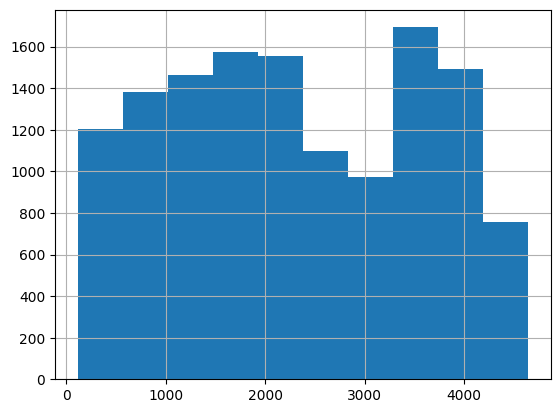

In [ ]:
df_plot = pd.read_csv(DIR + TRANSACTIONS, skiprows= lambda i: i>0 and random.random() > 0.01)
display(df_plot.head())
df_plot['price'].hist()

In [ ]:
# clustering result based on price time series. From "Clusturing" chapter
import matplotlib.colors as mcolors
clusters = pd.concat([pd.read_csv(DIR + 'class_10.csv'),
                      pd.read_csv(DIR + 'class_50.csv'),
                      pd.read_csv(DIR + 'class_100.csv'),
                      pd.read_csv(DIR + 'class_200.csv'),
                      pd.read_csv(DIR + 'class_300.csv'),
                      pd.read_csv(DIR + 'class_400.csv'),
                      pd.read_csv(DIR + 'class_400_DWT.csv'),
                      pd.read_csv(DIR + 'class_50_DWT.csv'),
                      pd.read_csv(DIR + 'class_200_DWT.csv'),
                      ]).query("`class` != -1").assign(sku_group = lambda x: x['interval'].astype(str) + '-' + x['class'].astype(str))[['SKU', 'sku_group']]
sku_group = clusters['sku_group'].drop_duplicates().to_list()
colors = list(mcolors.XKCD_COLORS.values())
palette = {sku_group[i] : colors[i] for i in range(len(sku_group))}

In [ ]:
(pd.read_csv(DIR + TRANSACTIONS, skiprows= lambda i: i>0 and random.random() > 0.01)
   .groupby('SKU').apply(lambda group: pd.Series({
           'unique_users': group['user'].nunique(),
           'mean_check' : group['price'].mean(),
           'max_price' : group['price'].max(),
           'min_price' : group['price'].min(),
           'num_purchase' : group['user'].count()
       }), include_groups=False
   )
).sort_values('num_purchase', ascending = False)

unique_users   mean_check  max_price  min_price  num_purchase
SKU                                                                 
67369          64.0  3649.546875     3770.0     3572.0          64.0
82649          55.0  2330.200000     2434.0     2147.0          55.0
87418          54.0  2752.722222     2828.0     2694.0          54.0
38664          54.0  2061.851852     2283.0     1782.0          54.0
87423          51.0  1154.634615     1189.0     1121.0          52.0
...             ...          ...        ...        ...           ...
32510           1.0   844.000000      844.0      844.0           1.0
95369           1.0  1327.000000     1327.0     1327.0           1.0
44124           1.0  2706.000000     2706.0     2706.0           1.0
81864           1.0  1964.000000     1964.0     1964.0           1.0
79558           1.0  3273.000000     3273.0     3273.0           1.0

[976 rows x 5 columns]

### SAMPLE_SKU

In [ ]:
MAX_DATE = pd.read_csv(DIR + SAMPLE_SKU).query(f"expiration_date < '{datetime.now().strftime(PANDAS_DATE_FORMAT)}'")['expiration_date'].max()
MAX_DATE = pd.to_datetime(MAX_DATE)

df_plot = (pd.read_csv(DIR + SAMPLE_SKU)
             .assign(creation_date = lambda x: pd.to_datetime(x['creation_date']))
             .assign(expiration_date = lambda x: pd.to_datetime(x['expiration_date']))
             .assign(expiration_date = lambda x: np.where(x['expiration_date'] > MAX_DATE, MAX_DATE.date(), x['expiration_date'].dt.date))
             .assign(expiration_date = lambda x: pd.to_datetime(x['expiration_date']))
             .assign(duration = lambda x: (x['expiration_date'] - x['creation_date']).dt.days)
            )
display(df_plot.head())
df_plot.groupby('brand_code').agg({'sku_id':'count'}).sort_values('sku_id', ascending = False)

sku_id fincode ui1_code ui2_code ui3_code  vendor brand_code creation_date  \
0   16663      Z8      Z81    Z8100  Z810000  FI3ASO   THSTSG81    2018-06-26   
1   91775      Q5      Q51    Q5100  Q510008  4O4WSH   WKXRWTP7    2019-07-07   
2   24641      ZR      ZR1    ZR100  ZR10000  71SM2O   J8XKU94W    2019-05-22   
3   84184      UA      UA1    UA102  UA10205  FI3ASO   5IEJMU4O    2018-04-19   
4   21070      XG      XG1    XG100  XG10000  4O4WSH   4WL34OA2    2019-06-27   

  expiration_date  duration  
0      2019-04-21       299  
1      2019-12-30       176  
2      2019-12-30       222  
3      2019-06-19       426  
4      2019-12-30       186

sku_id
brand_code        
8FYENEWM        59
4WL34OA2        43
THSTSG81        34
5QQF7PWJ        32
9XGMSC3X        31
...            ...
1VPSWMTF         5
SKXXW8V9         4
8QJHUA65         4
74CKJ9XQ         3
H1BWFJRN         2

[62 rows x 1 columns]

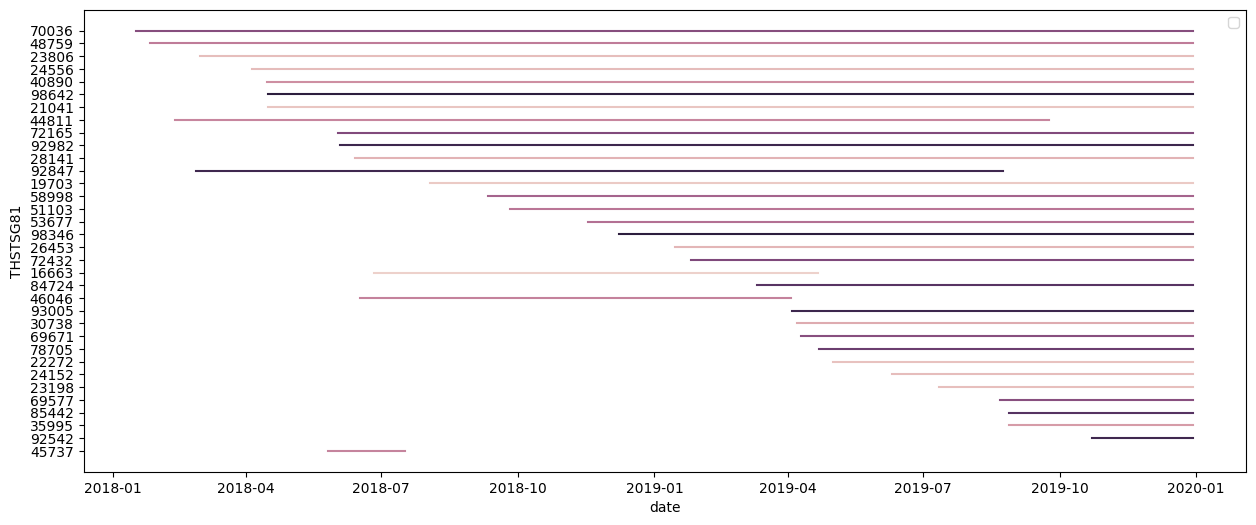

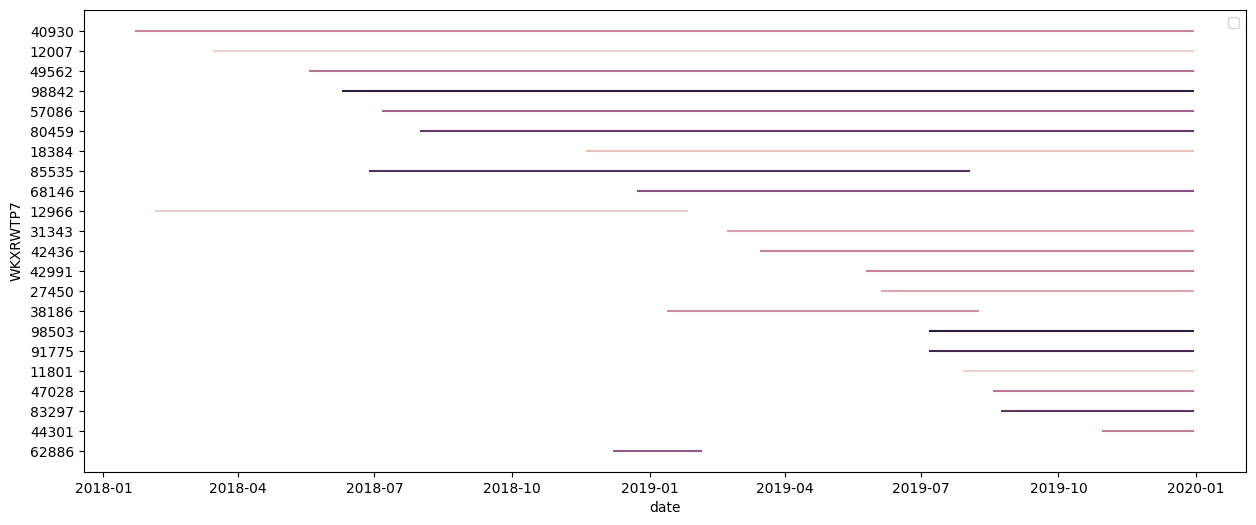

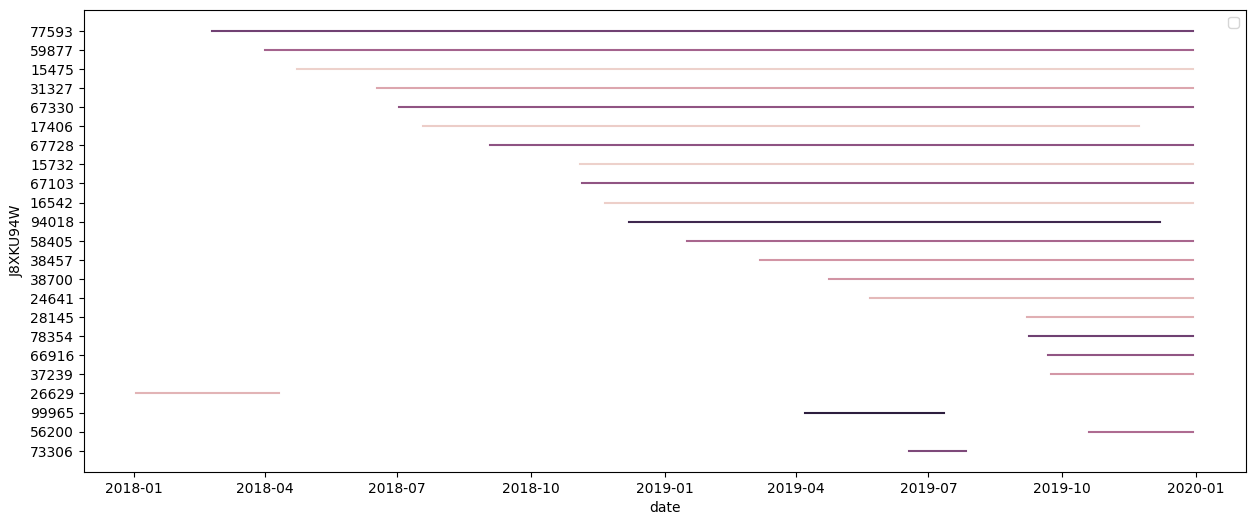

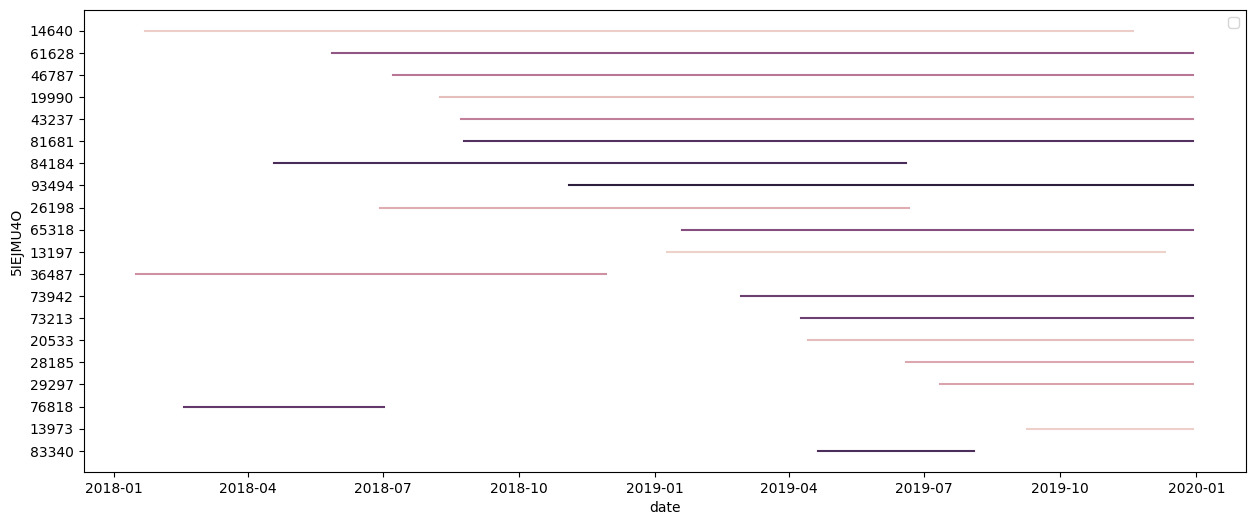

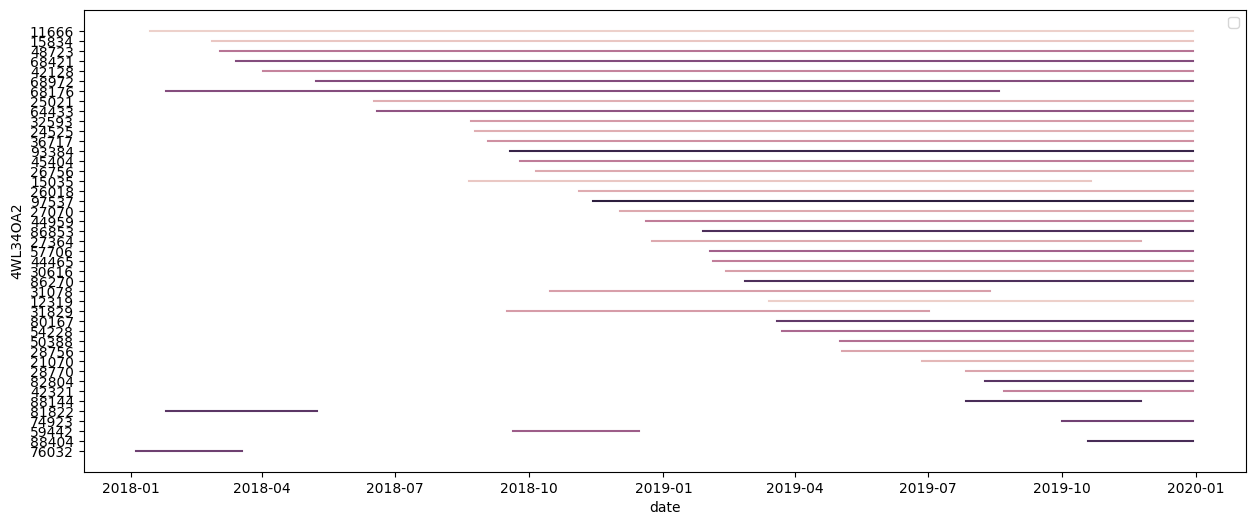

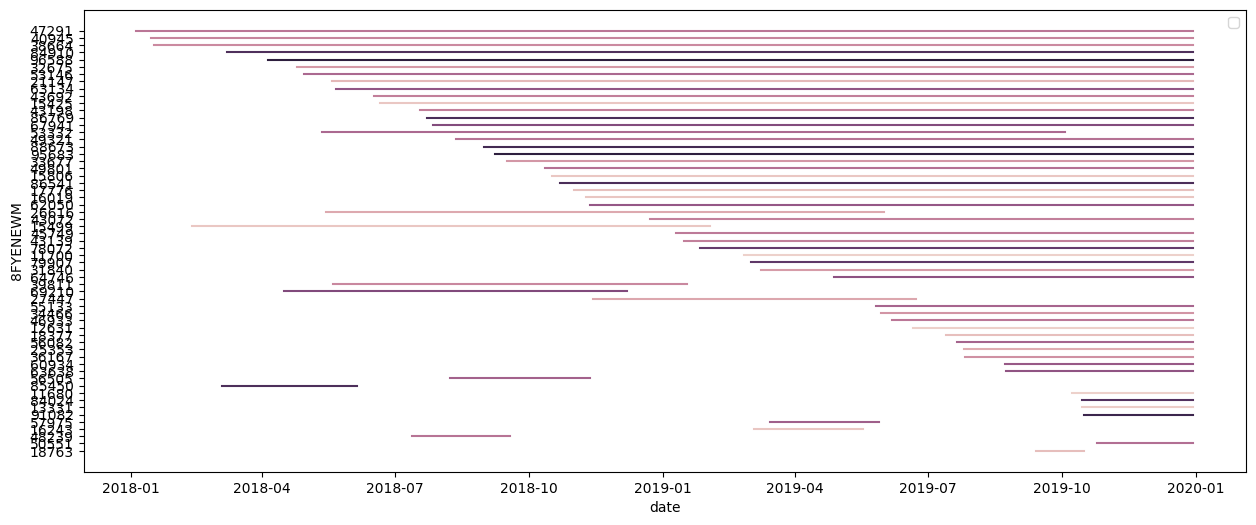

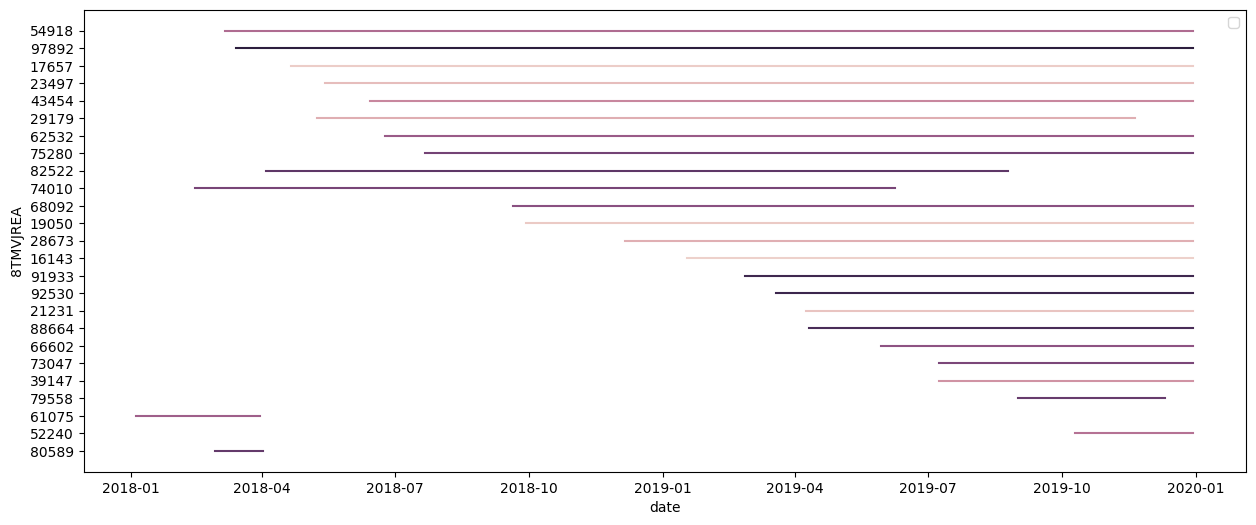

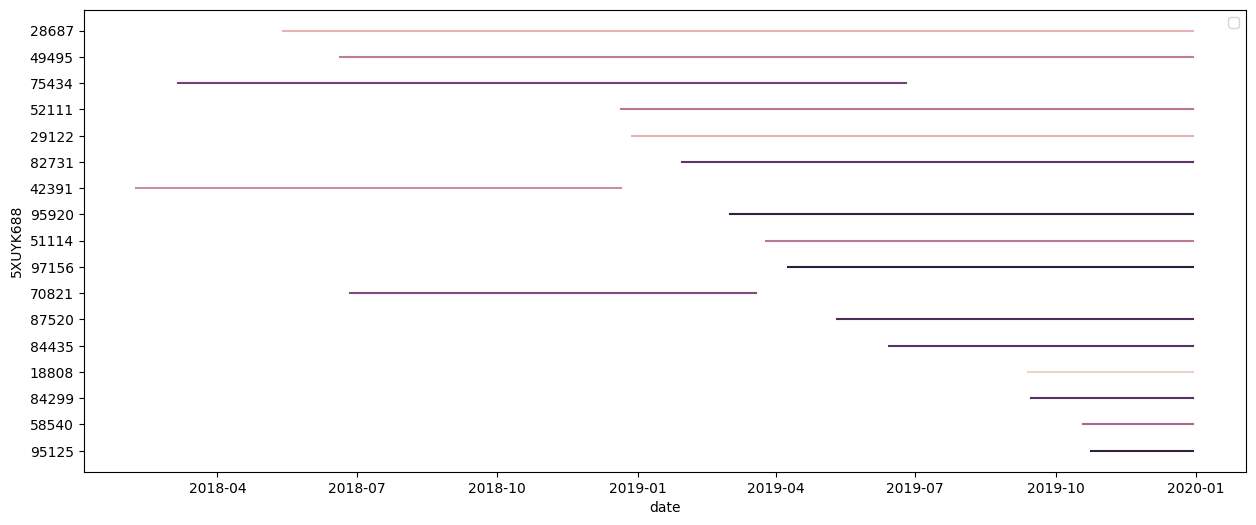

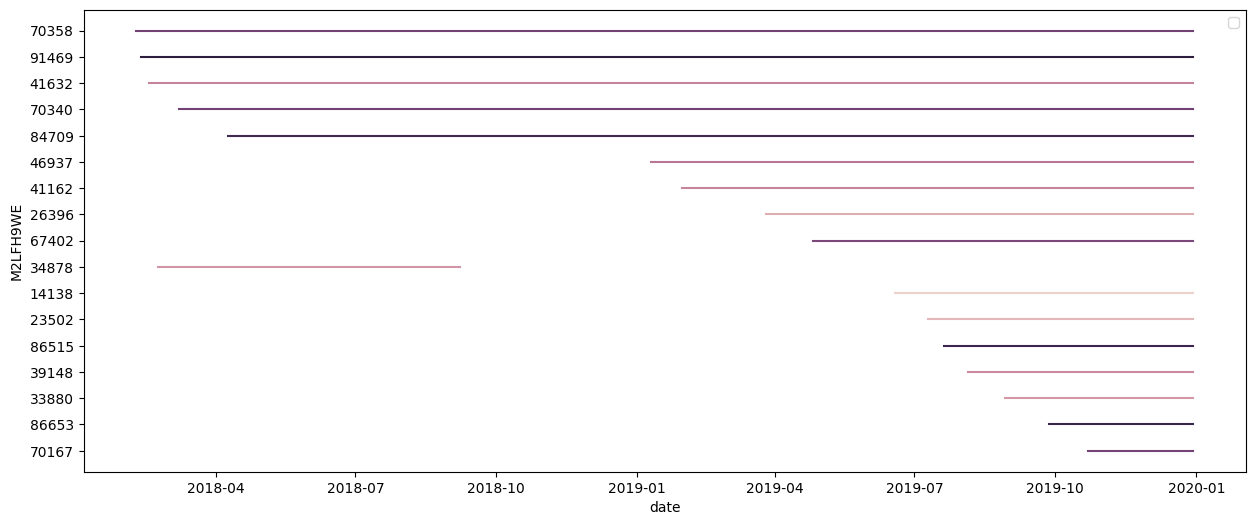

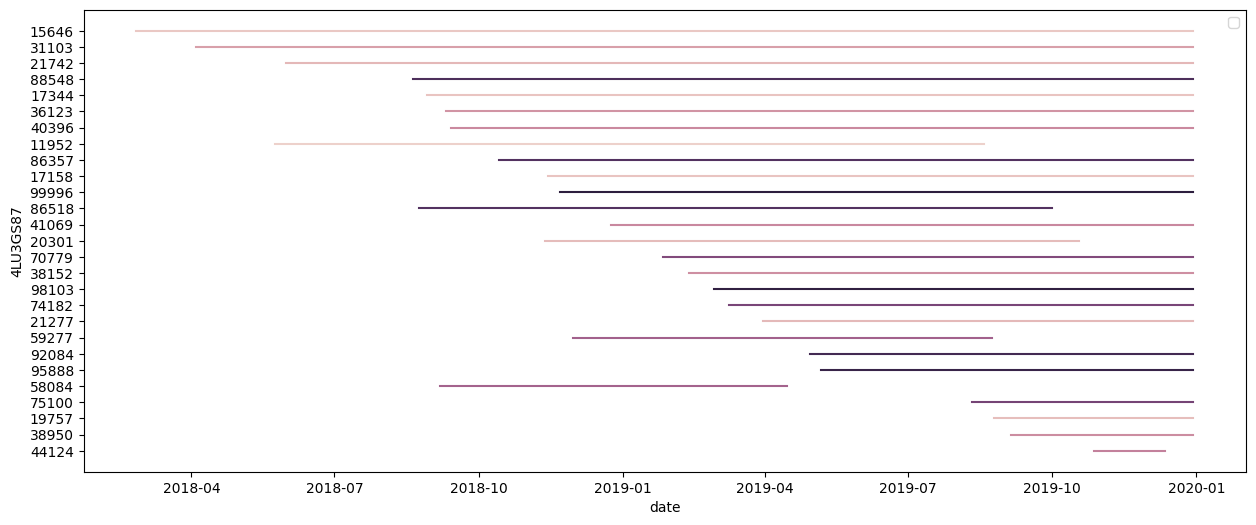

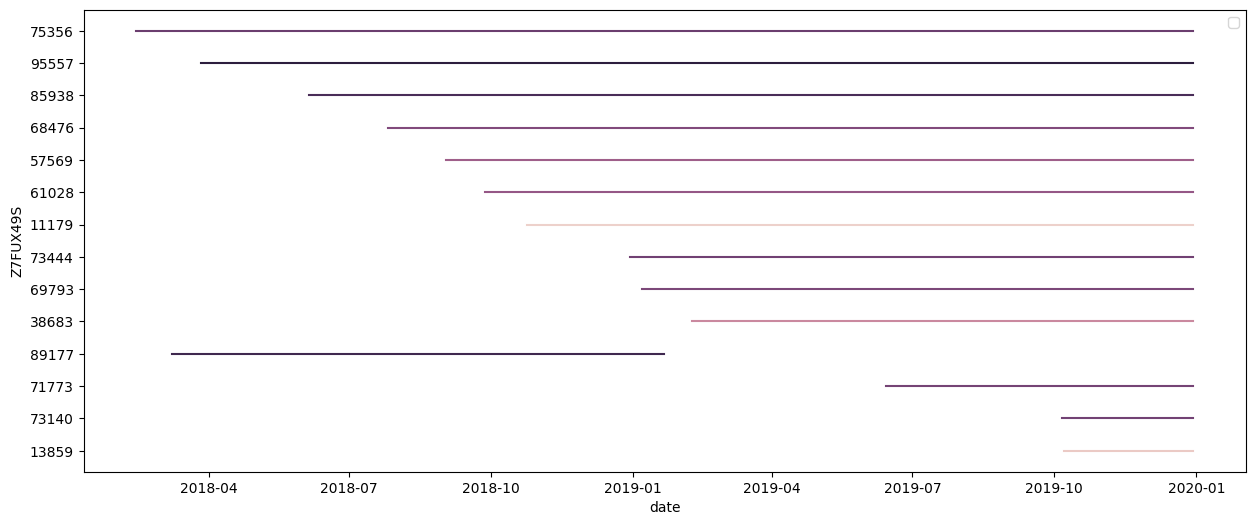

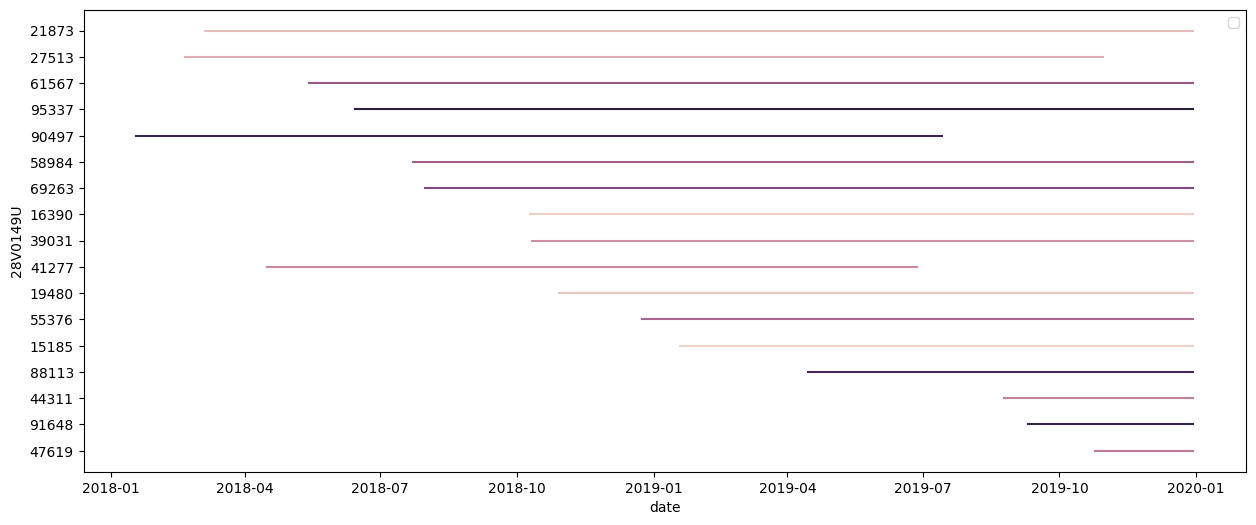

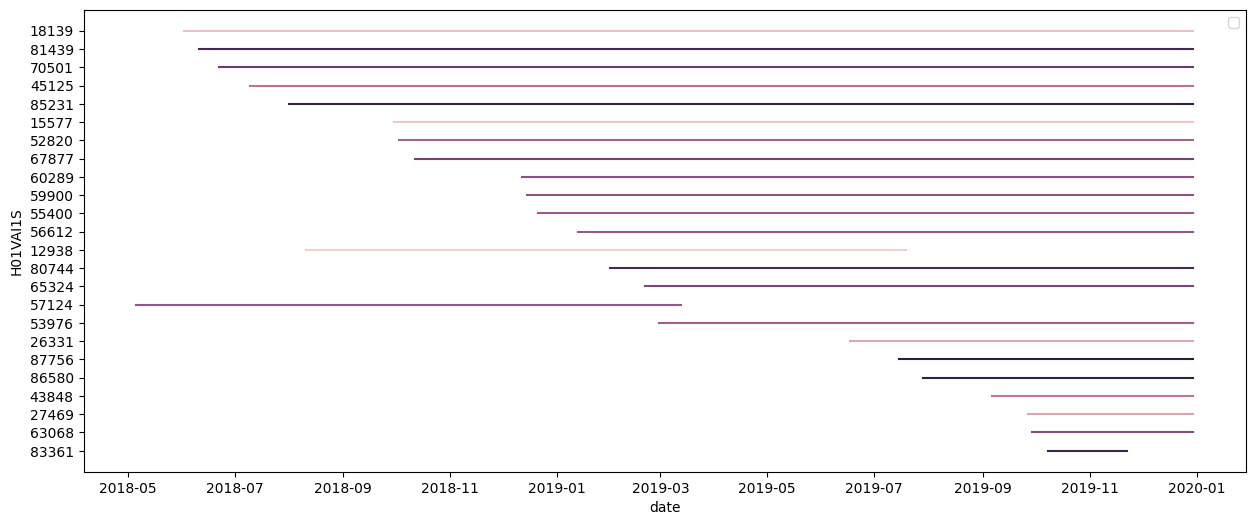

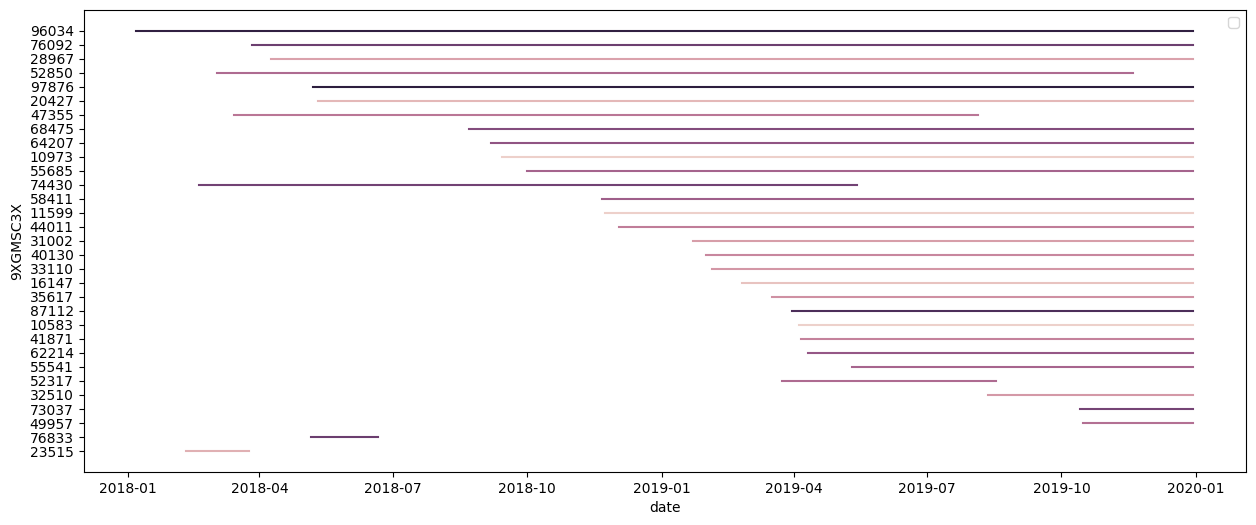

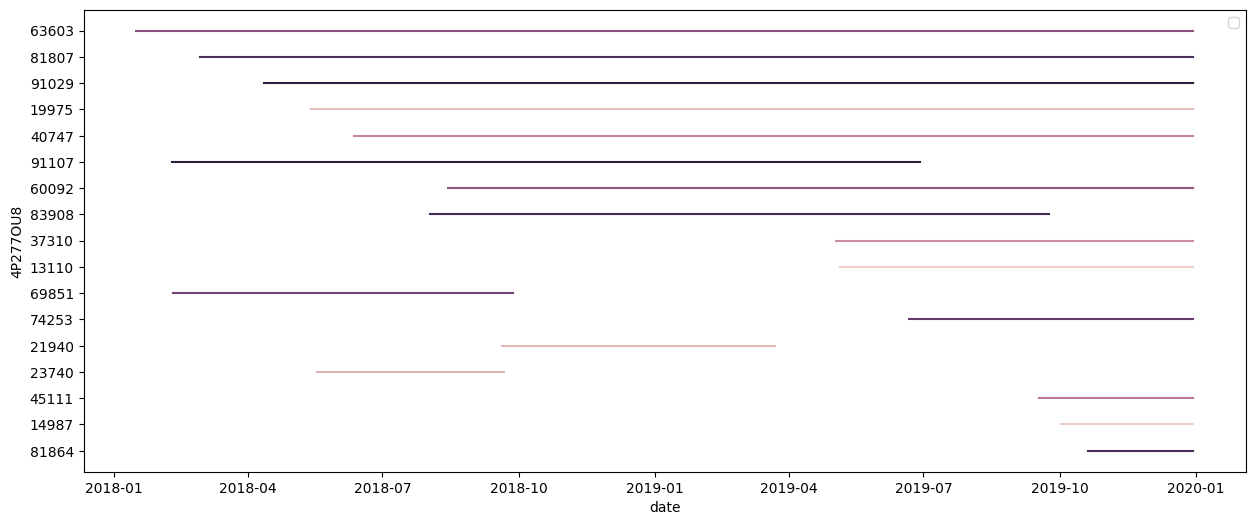

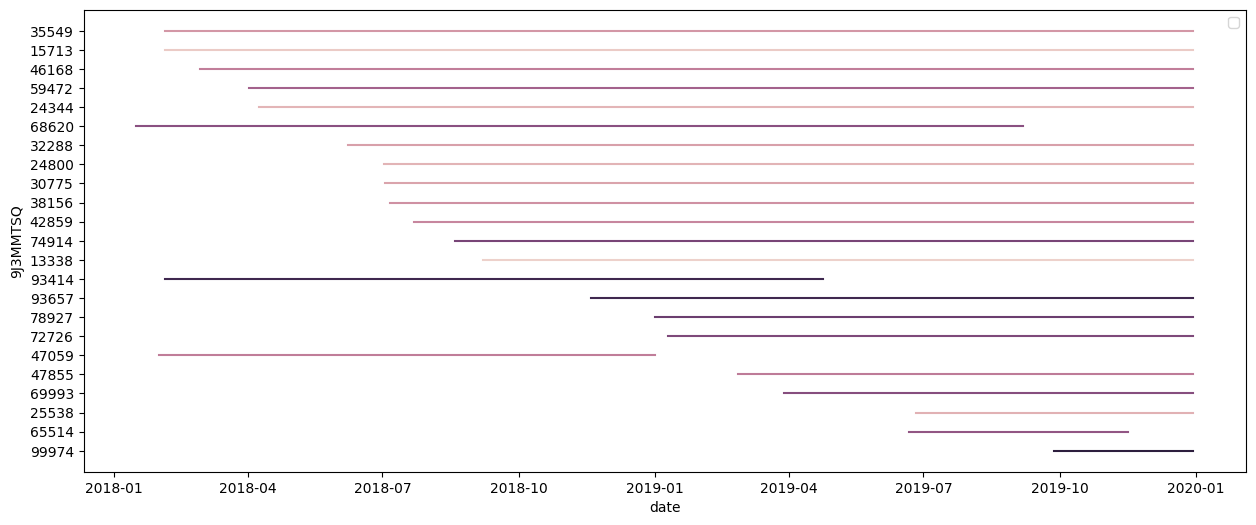

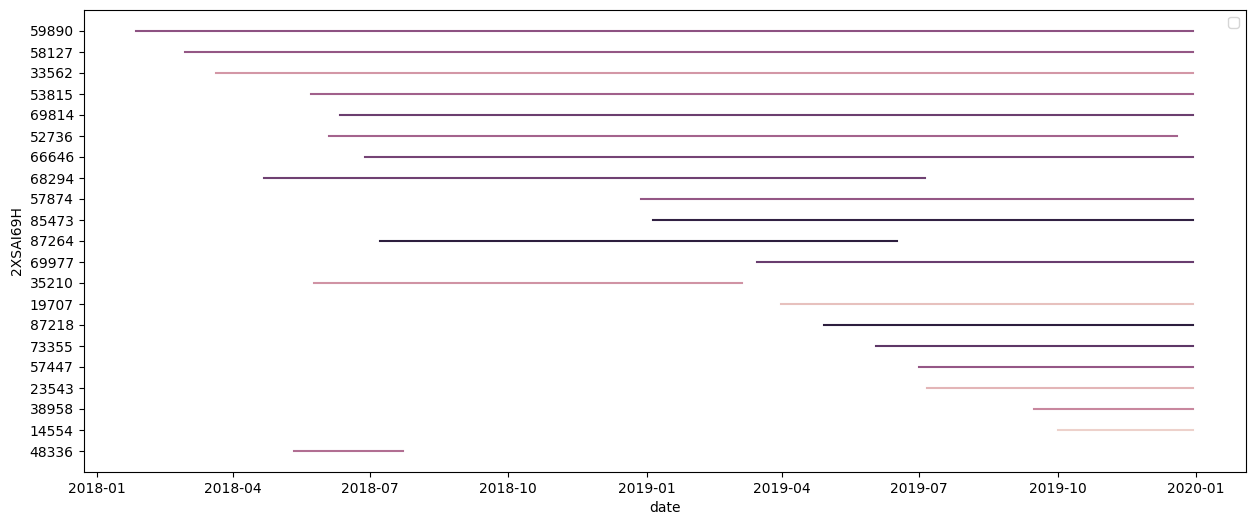

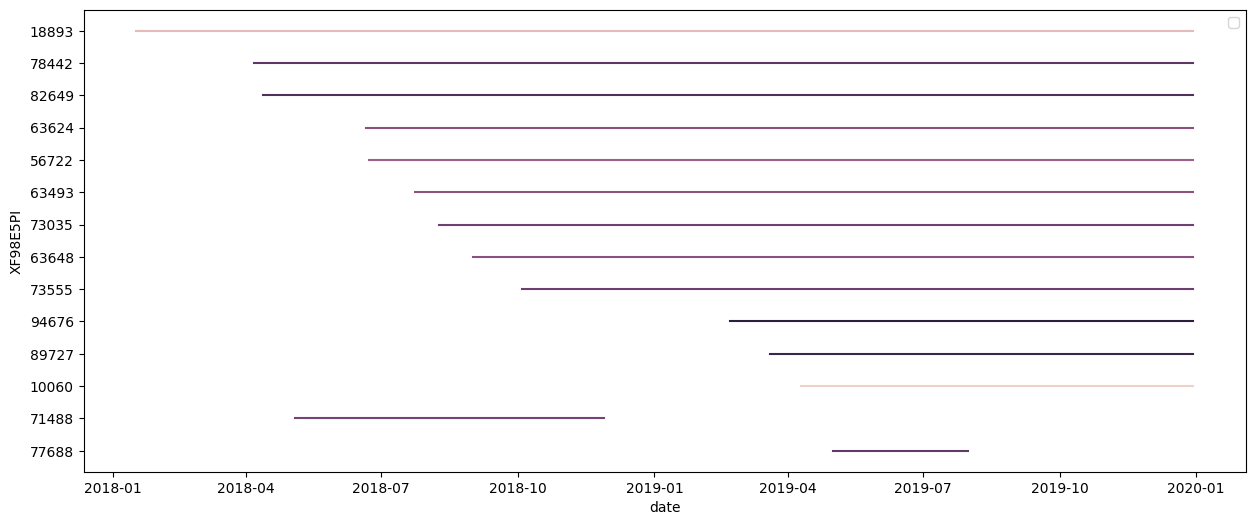

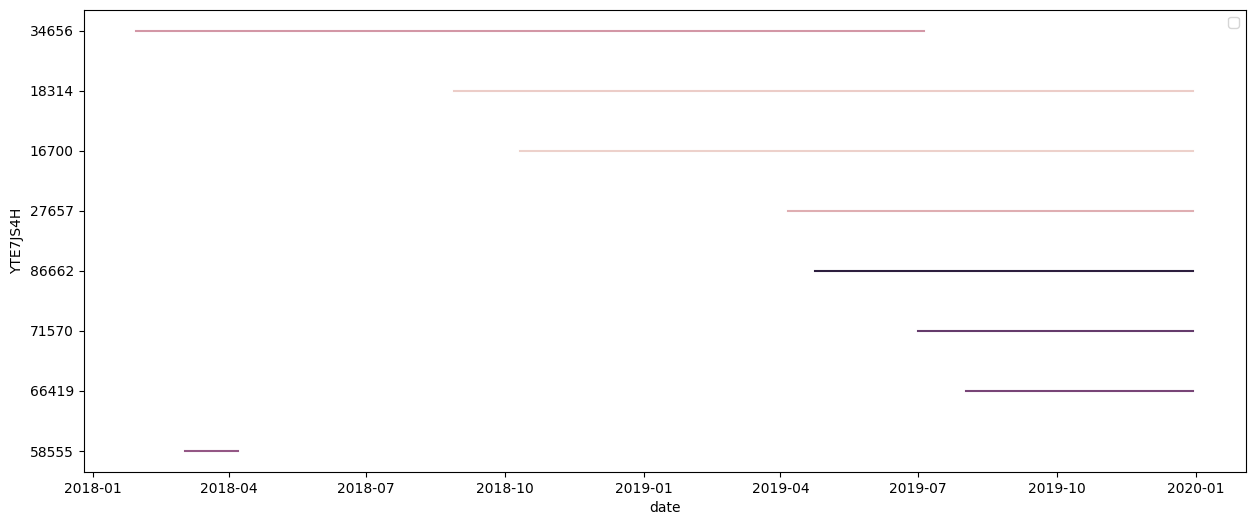

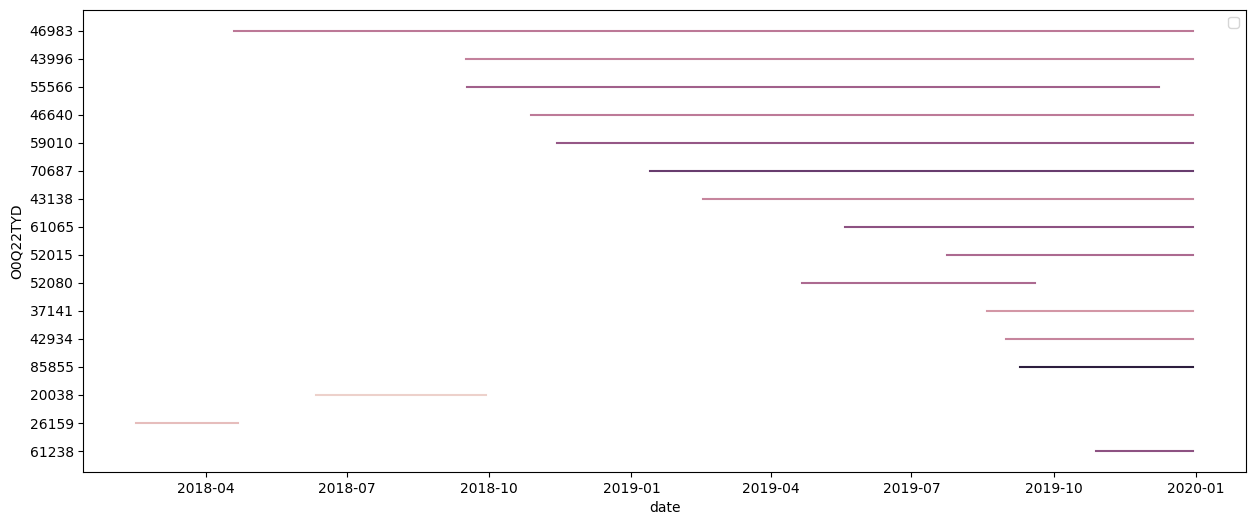

In [ ]:
# MAX_DATE = df_plot.query(f"expiration_date < '{datetime.now().strftime(PANDAS_DATE_FORMAT)}'")['expiration_date'].max()
NUM_OF_BRANDS = 20

_ = (pd.concat([
                df_plot[['sku_id', 'brand_code', 'creation_date', 'duration']].rename(columns = {'creation_date':'date'}),
                df_plot[['sku_id', 'brand_code', 'expiration_date', 'duration']].rename(columns = {'expiration_date':'date'})
                ])
       .assign(date = lambda x: np.where(x['date'] > MAX_DATE, MAX_DATE.date(), x['date'].dt.date
                                         )))
for brand in _['brand_code'].unique()[:NUM_OF_BRANDS]:
  data = (_.query("brand_code == @brand")
           .sort_values(['brand_code', 'duration', 'sku_id'], ascending=False)
           .assign(rank = lambda x: x[['duration','sku_id']].apply(tuple,axis=1).rank(method = 'dense')))
  plt.figure(figsize = (15,6))
  ax = sns.lineplot(data, x = 'date', y = 'rank', hue = 'sku_id')
  ax.set_yticks(ticks=data['rank'].sort_values().unique(), labels=data[['rank', 'sku_id']].sort_values(['rank'])['sku_id'].astype(str).unique())
  plt.legend([])
  plt.ylabel(brand)
  plt.show()

### PROMO

max_discount  min_discount  mean_discount  cnt_discount
year SKU                                                           
2019 11799          0.20          0.05       0.095918          49.0
     43996          0.20          0.05       0.102041          49.0
     11189          0.20          0.05       0.096875          48.0
     15425          0.20          0.05       0.094792          48.0
     42888          0.20          0.05       0.093750          48.0
...                  ...           ...            ...           ...
2018 16019          0.15          0.05       0.100000           8.0
     67286          0.20          0.05       0.093750           8.0
     28188          0.20          0.15       0.175000           4.0
     11189          0.15          0.05       0.100000           3.0
     43072          0.10          0.10       0.100000           1.0

[78 rows x 4 columns]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


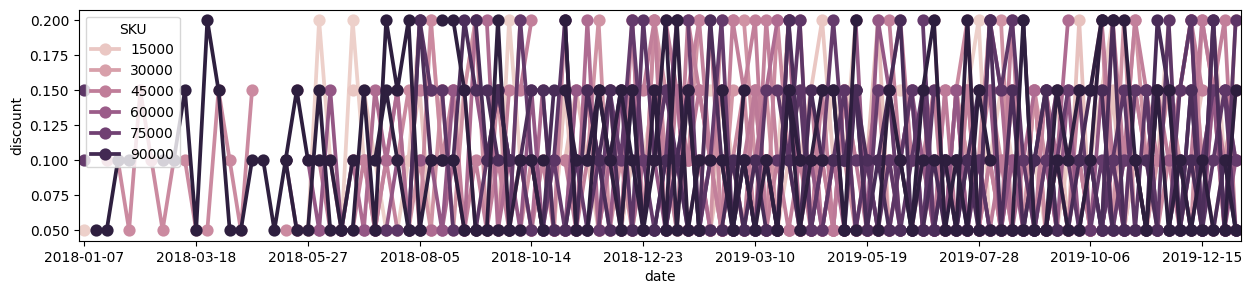

In [ ]:
GB = ['year', 'SKU']
_ = (pd.read_csv(DIR + PROMO)
   .groupby(GB).apply(lambda group: pd.Series({
        'max_discount': group['discount'].max(),
        'min_discount': group['discount'].min(),
        'mean_discount': group['discount'].mean(),
        'cnt_discount': group['discount'].count(),
    }),include_groups=False)
   .sort_values(['year', 'cnt_discount'], ascending = False)
)
SKUs = _.reset_index().query("cnt_discount > 45")['SKU'].unique()
display(_)

df_plot = (pd.read_csv(DIR + PROMO)
   .assign(formatted_date = lambda x: x['year'] * 1000 + x['week_num'] * 10 + 0)
   .assign(date = lambda x: pd.to_datetime(x['formatted_date'], format='%Y%W%w'))
   .query("SKU.isin(@SKUs)")
  #  .groupby(['SKU', 'date']).agg({'':'mean'})
)
plt.figure(figsize = (15, 3))
ax = sns.pointplot(data = df_plot, x = 'date', y = 'discount', hue = 'SKU')
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
plt.show()

### CANC_PRICE

In [ ]:
GB = ['SKU', 'year', 'week_num']
prices = (pd.read_csv(DIR + TRANSACTIONS)
   .assign(dates = lambda x: pd.to_datetime(x['dates']))
   .assign(year = lambda x: x['dates'].dt.year)
   .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
   .groupby(GB)
   .agg({'price':'mean'})
   .reset_index()
)

df_plot = (pd.read_csv(DIR + CANC_PRICE).merge(prices, on = GB, how = 'left')
             .query("~price.isna()")
)

ret_net_1_price  ret_net_2_price  ret_net_3_price
count      9259.000000      9259.000000      9259.000000
mean          0.002055        -0.017271        -0.004437
std           0.996632         1.498821         1.195966
min          -3.631597        -5.951857        -5.066930
25%          -0.665046        -1.042673        -0.796805
50%           0.007776        -0.021056        -0.013970
75%           0.671181         0.990614         0.798757
max           3.528724         6.294199         4.513970

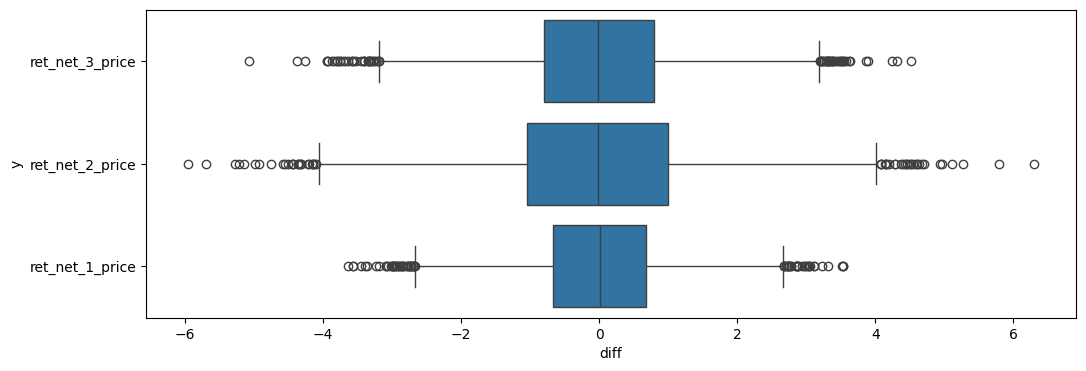

In [ ]:
canc_list = ['ret_net_1_price', 'ret_net_2_price', 'ret_net_3_price']

data = pd.DataFrame()
data_describe = pd.DataFrame()
for i, canc in enumerate(canc_list):
  _ = (df_plot.assign(diff = lambda x: (x[canc] - x['price']) / x['price'] * 100)
              .assign(y = canc)
              [['diff', 'y']]
  )
  data = pd.concat([_, data])
  describe_current  =_.describe().rename(columns = {'diff':canc})
  if data_describe.empty: data_describe = describe_current
  else: data_describe = data_describe.merge(describe_current, how = 'left', left_index=True, right_index=True)

display(data_describe)
plt.figure(figsize=(12,4))
sns.boxplot(data, x = 'diff', y = 'y')
plt.show()

### SALES_PLAN

In [ ]:
GB = ['SKU', 'year', 'month']
sales = (pd.read_csv(DIR + TRANSACTIONS)
   .assign(dates = lambda x: pd.to_datetime(x['dates']))
   .assign(year = lambda x: x['dates'].dt.year)
   .assign(month = lambda x: x['dates'].dt.month)
   .groupby(GB)
   .agg({'price':'count'})
   .rename(columns = {'price':'fact'})
   .reset_index()
)

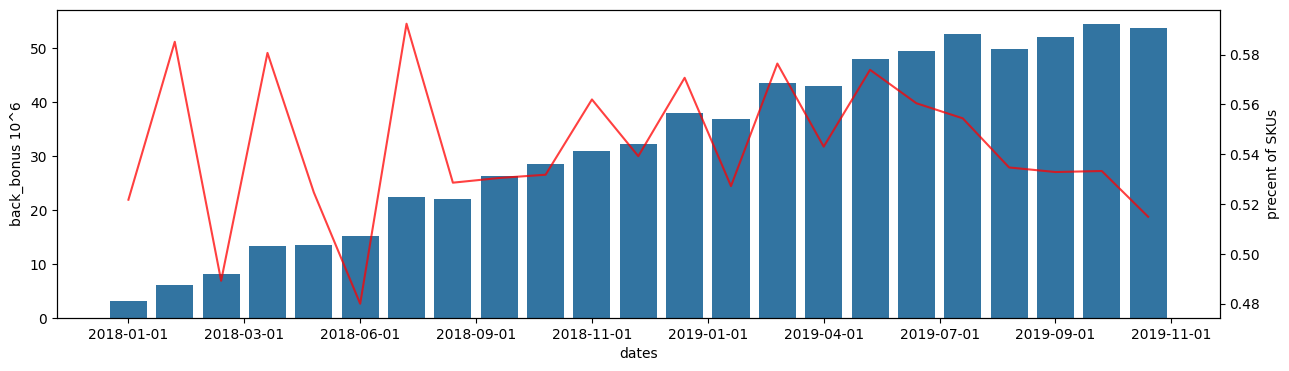

In [ ]:
df_plot = (pd.read_csv(DIR + SALES_PLAN)
             .merge(sales, on = GB, how = 'left').query("~fact.isna()")
             .assign(dates = lambda x: pd.to_datetime(x['year'].astype(str)  + x['month'].astype(str), format='%Y%m'))
             .groupby(['dates'])
             .apply(lambda group: pd.Series({
                  'back_bonus': sum(np.where(group['plan'] <= group['fact'], group['back_bonus'], 0)) / 1_000_000,
                  'precent': sum(np.where(group['plan'] <= group['fact'],1, 0)) / group.shape[0]
              }), include_groups=False)
)
plt.figure(figsize = (15, 4))
ax = sns.barplot(df_plot, x= 'dates', y = 'back_bonus')
ax_2 = ax.twinx()
ax_2.plot(ax.get_xticks(), df_plot['precent'].values, alpha = .75, color = 'r')
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
ax.set_ylabel('back_bonus 10^6'), ax_2.set_ylabel('precent of SKUs')
plt.show()

### TRADES

In [ ]:
GB = ['SKU', 'year', 'week_num']
sales = (pd.read_csv(DIR + TRANSACTIONS)
   .assign(dates = lambda x: pd.to_datetime(x['dates']))
   .assign(year = lambda x: x['dates'].dt.year)
   .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
   .groupby(GB)
   .agg({'user':'count', 'price': 'sum'})
   .rename(columns = {'price':'sum', 'user': 'count'})
   .reset_index()
)

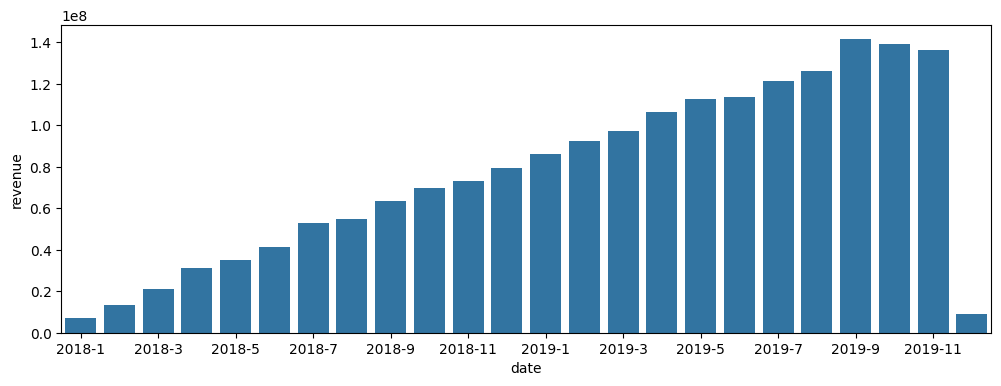

In [ ]:
data = (pd.read_csv(DIR + TRADES).merge(sales, on = GB, how = 'left')
   .assign(trade_sum = lambda x: x['cost_price'] * x['count'])
   .groupby(['SKU', 'year', 'month']).agg({'trade_sum':'sum', 'count': 'sum', 'sum':'sum'})
   .merge(pd.read_csv(DIR + SALES_PLAN), on = ['SKU', 'year', 'month'], how = 'left')
   .assign(revenue = lambda x: x['sum'] - x['trade_sum'] + np.where(x['count'] >= x['plan'], x['back_bonus'], 0))
   .groupby(['year', 'month'])
   .agg({'revenue': 'sum'})
    .reset_index()
    .assign(date = lambda x: x['year'].astype(str) + '-' + x['month'].astype(str))
)
plt.figure(figsize=(12,4))
ax = sns.barplot(data = data, x = 'date', y = 'revenue' )
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

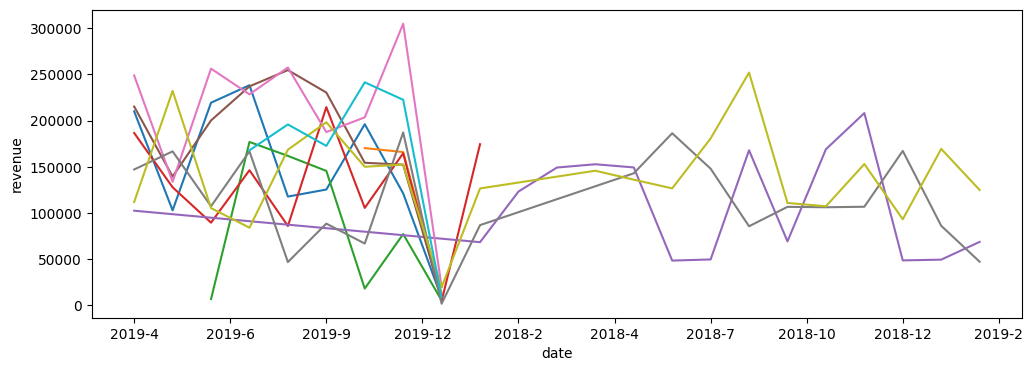

In [ ]:
SKUs = pd.read_csv(DIR + TRADES)['SKU'].unique()
plt.figure(figsize=(12,4))
for SKU in SKUs[0:10]:
  data = (pd.read_csv(DIR + TRADES).merge(sales, on = GB, how = 'left')
    .assign(trade_sum = lambda x: x['cost_price'] * x['count'])
    .query("SKU == @SKU")
    .groupby(['SKU', 'year', 'month']).agg({'trade_sum':'sum', 'count': 'sum', 'sum':'sum'})
    .merge(pd.read_csv(DIR + SALES_PLAN), on = ['SKU', 'year', 'month'], how = 'left')
    .assign(revenue = lambda x: x['sum'] - x['trade_sum'] + np.where(x['count'] >= x['plan'], x['back_bonus'], 0))
    .sort_values(['SKU', 'year', 'month'])
    .assign(date = lambda x: x['year'].astype(str) + '-' + x['month'].astype(str))
  )

  ax = sns.lineplot(data = data, x = 'date', y = 'revenue')
  ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
plt.show()

## Clustering SKUs

Semi-Manual Clustering Approach

Algorithm:

1. Split the data based on series size (more than 400, between 400 and 300, 300-200, etc.).
1. Cluster each split using embeddings.
1. As a result, assign clusters with names [0, 1, 2, ...] and another unclusterized data named -1.
1. Repeat splitting and clustering for cluster -1 using the DWT time series k-means approach.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense

data = pd.read_csv(DIR + TRADES).assign(dates = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))

In [ ]:
GB = ['SKU', 'dates']
data = pd.read_csv(DIR + TRANSACTIONS).groupby(GB).agg({'price':'mean'}).reset_index().sort_values(GB).rename(columns = {'price':'cost_price'})

In [ ]:
SKUs = data.merge(unclassify[['SKU']], on = 'SKU').groupby('SKU').agg({'cost_price':'count'}).query("(cost_price <= 200)&(cost_price> 0)").reset_index()['SKU'].unique()

In [ ]:
len(SKUs)

177

In [ ]:
GB = ['dates']
base = data[GB].drop_duplicates().sort_values(GB)

In [ ]:
scaler = StandardScaler()
data_wmv = pd.DataFrame()
for SKU in SKUs:
  curr_df = (base.merge(data.query("SKU == @SKU"), on = GB, how = 'left')
                        #  .assign(price_per_sku = lambda x: missingvalues.fit_transform(x[['price_per_sku']]))
                         .assign(cost_price_default = lambda x: x['cost_price'])
                         .assign(cost_price = lambda x: scaler.fit_transform(x[['cost_price']]))
                         .assign(cost_price = lambda x: x[['cost_price']].ffill().bfill())
                         .assign(SKU = SKU)
                     ).query("~cost_price.isna()")
  data_wmv = pd.concat([data_wmv, curr_df])

In [ ]:
input_dim = 50
GB = ['SKU', 'dates']
SKUs = data_wmv.SKU.unique()
batches = np.zeros(( len(SKUs), input_dim))

for index, SKU in enumerate(SKUs):
  df_train = data_wmv.query("SKU == @SKU").sort_values(GB)[['cost_price']]

  scaler = StandardScaler().fit(df_train)
  df_train = scaler.transform(df_train)[:input_dim]
  batches[index] = df_train.reshape(-1)
time_series_data = batches

**Embeddings approach**

In [ ]:
# Размерность эмбеддинга
encoding_dim = 12  # Вы можете выбрать размерность эмбеддинга в зависимости от задачи

# Определение слоев автоэнкодера
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Создание модели автоэнкодера
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Создание модели кодировщика для получения эмбеддингов
encoder = Model(inputs=input_layer, outputs=encoded)

# Компиляция модели
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
# Поскольку у нас только один временной ряд, мы можем использовать его как вход и выход
autoencoder.fit(time_series_data, time_series_data,
                epochs=30,
                batch_size=1,
                shuffle=True)

# Получение эмбеддингов
embeddings = encoder.predict(time_series_data)

# Вывод эмбеддингов
print("Embeddings shape:", embeddings.shape)
print(embeddings)  # Печать эмбеддингов
clear_output()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

kmeans = DBSCAN(eps=13).fit(embeddings)
# kmeans = AgglomerativeClustering(n_clusters = 3).fit(embeddings)
class_df = pd.DataFrame({'SKU':list(SKUs), 'class' : list(kmeans.labels_)})
data_wmv = data.merge(class_df, how = 'left', on = 'SKU')

ValueError: All arrays must be of the same length

**DWT Time Series clustering**

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
kmeans = TimeSeriesKMeans(n_clusters=6, metric="dtw",
                         max_iter=20)
kmeans.fit(time_series_data)
class_df = pd.DataFrame({'SKU':list(SKUs), 'class' : list(kmeans.labels_)})
data_wmv = data.merge(class_df, how = 'left', on = 'SKU')

In [ ]:
data_wmv.query("~`class`.isna()")['class'].unique()

array([2., 3., 0., 1., 5., 4.])

In [ ]:
# for EMBEDDINGS approach only. Visualize embeddings as PCA components
from sklearn.decomposition import PCA

# Assuming 'embeddings' is already defined from the previous code
pca = PCA(n_components = 4)
embeddings_2d = pca.fit_transform(embeddings)

pca_df = pd.DataFrame({'SKU':list(SKUs), 'class' : list(kmeans.labels_),'pca_1': list(embeddings_2d[:,0]),'pca_2' : list(embeddings_2d[:,1]), 'pca_3' : list(embeddings_2d[:,2]), 'pca_4' : list(embeddings_2d[:,3])})
sns.scatterplot(data = pca_df, x = 'pca_1', y = 'pca_2', hue = 'class')
plt.show()
sns.scatterplot(data = pca_df, x = 'pca_2', y = 'pca_3', hue = 'class')
plt.show()
sns.scatterplot(data = pca_df, x = 'pca_1', y = 'pca_3', hue = 'class')
plt.show()
sns.scatterplot(data = pca_df, x = 'pca_2', y = 'pca_4', hue = 'class')
plt.show()

ValueError: All arrays must be of the same length

2.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


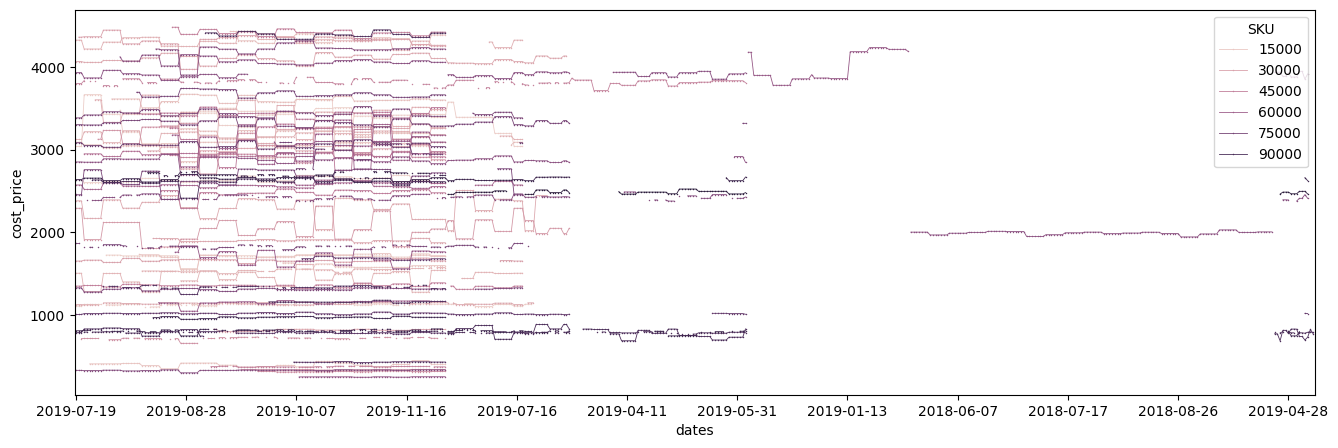

3.0


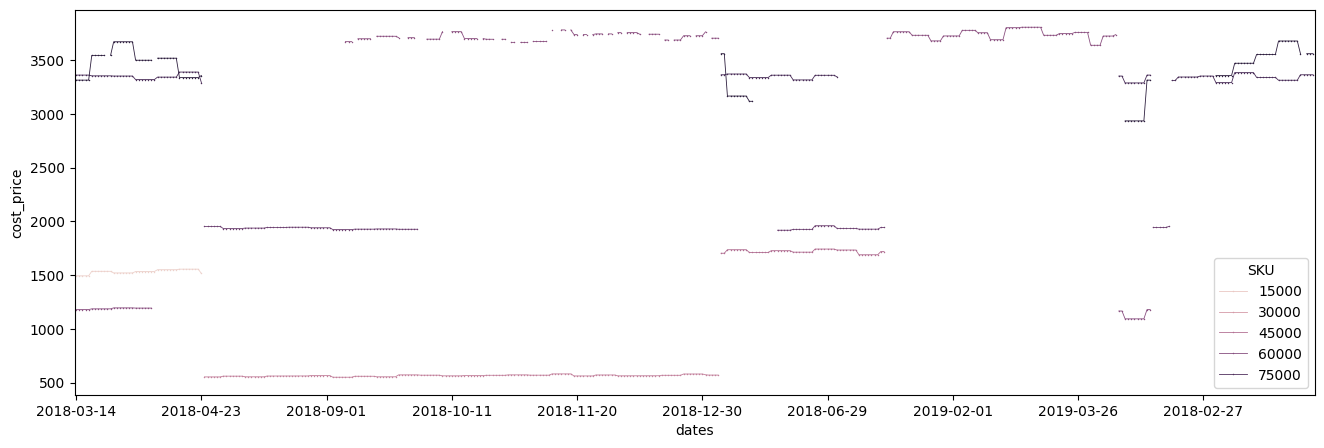

0.0


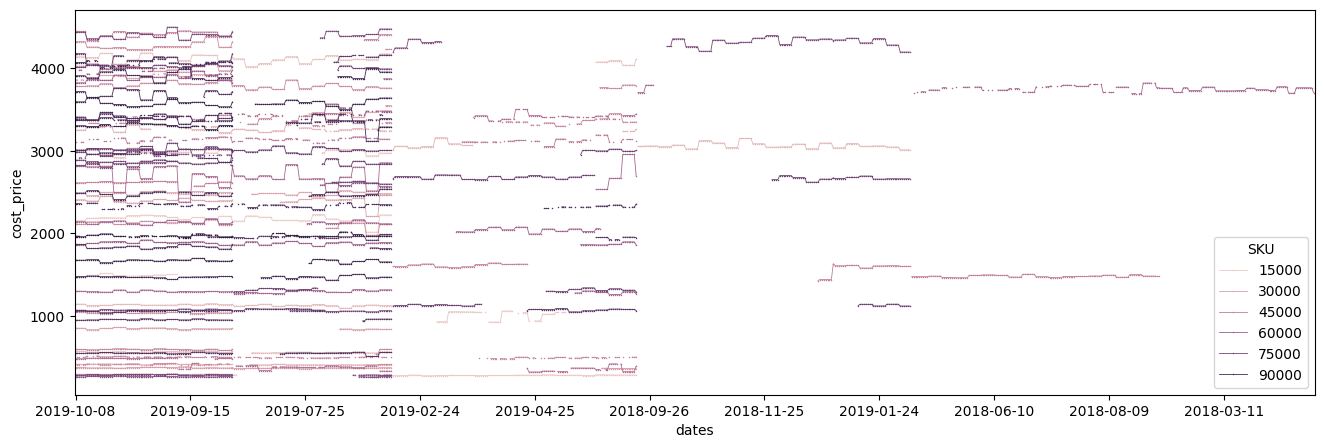

1.0


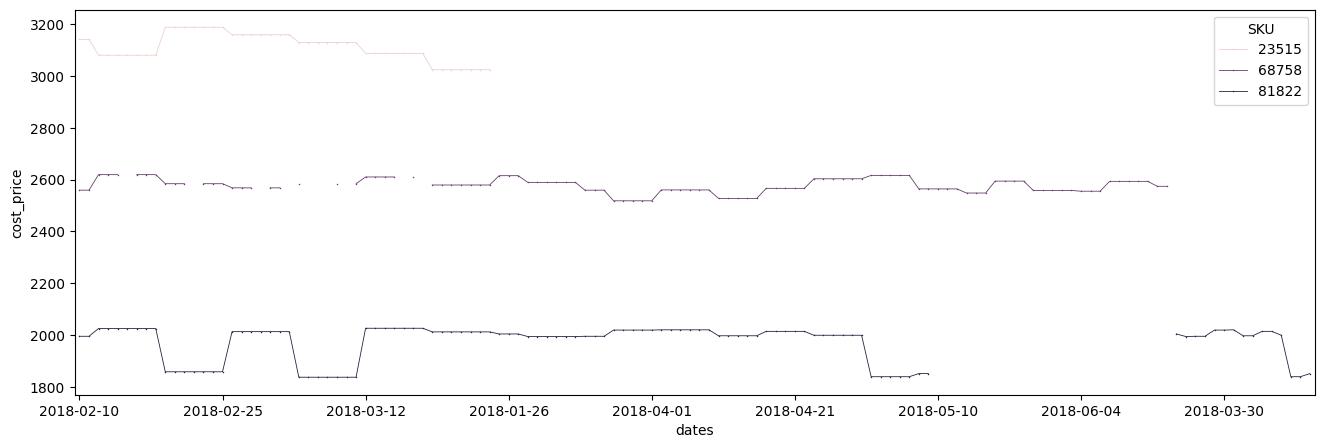

5.0


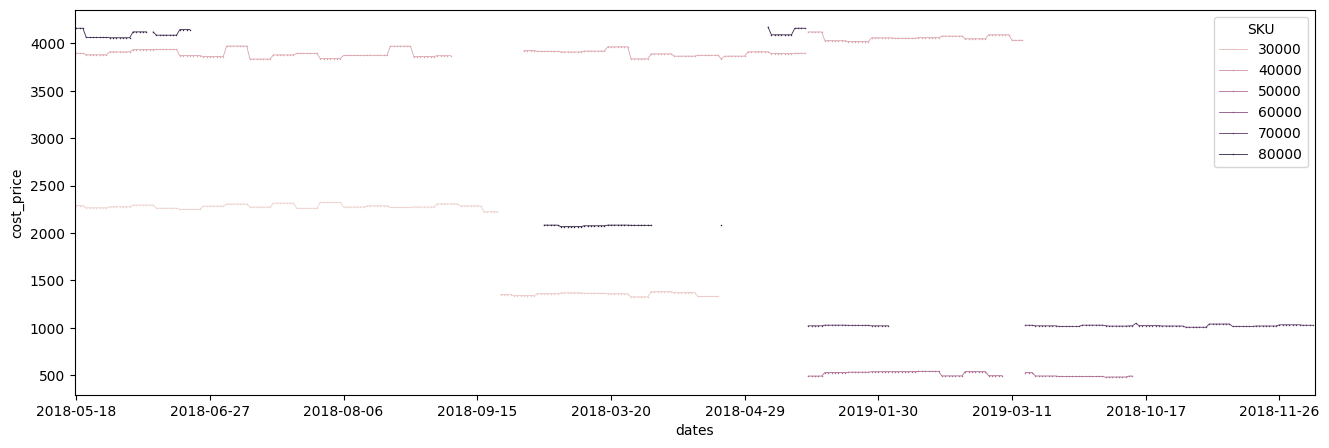

4.0


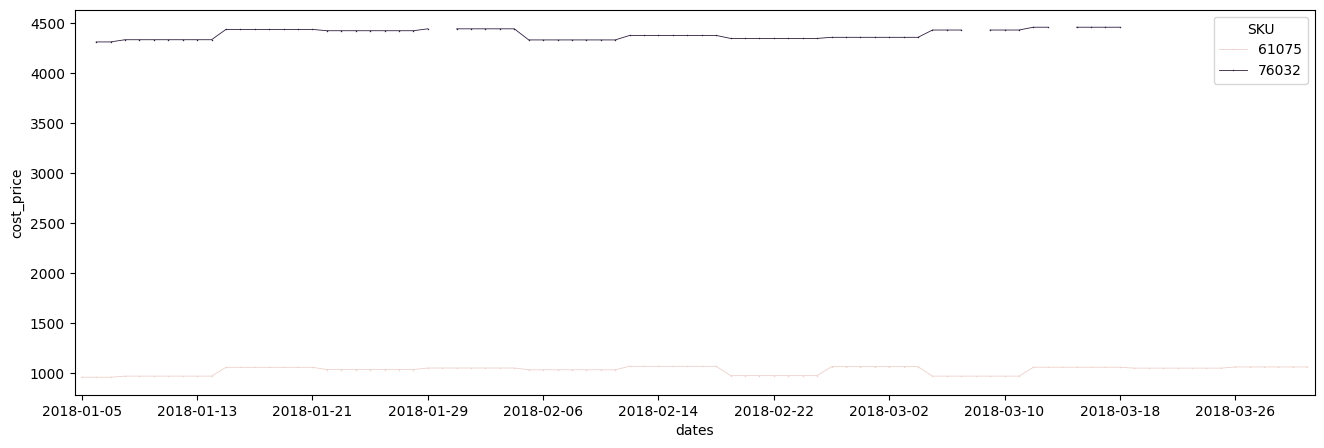

In [ ]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())
get_color = lambda x: colors[(len(colors) + x) % len(colors)]

for cls in [i for i in data_wmv.query("~`class`.isna()")['class'].unique() if i != -1]:
  fig, ax = plt.subplots(1,1, figsize = (16, 5))

  df_plot = data_wmv.query("`class` == @cls")
  print(cls)
  color = df_plot['class'].iloc[0]
  sns.pointplot(data = df_plot, x = 'dates', y = 'cost_price',  ax = ax,  hue = 'SKU', markersize = 0.6, linewidth = 0.6)
  ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
  plt.show()
  # plt.legend()

In [ ]:
class_df.assign(interval = '50_DWT').to_csv("class_50_DWT.csv")

In [ ]:
# unclassify = pd.concat([pd.read_csv(DIR + 'class_10.csv'),
#                         pd.read_csv(DIR + 'class_50.csv'),
#                         pd.read_csv(DIR + 'class_100.csv'),
#                         pd.read_csv(DIR + 'class_200.csv'),
#                         pd.read_csv(DIR + 'class_300.csv'),
#                         pd.read_csv(DIR + 'class_400.csv'),
#                         ]).query("`class` == -1")

In [ ]:
clusters = pd.concat([pd.read_csv(DIR + 'class_10.csv'),
                      pd.read_csv(DIR + 'class_50.csv'),
                      pd.read_csv(DIR + 'class_100.csv'),
                      pd.read_csv(DIR + 'class_200.csv'),
                      pd.read_csv(DIR + 'class_300.csv'),
                      pd.read_csv(DIR + 'class_400.csv'),
                      pd.read_csv(DIR + 'class_400_DWT.csv'),
                      pd.read_csv(DIR + 'class_50_DWT.csv'),
                      pd.read_csv(DIR + 'class_200_DWT.csv'),
                      ]).query("`class` != -1")

## num_purchase price model

In [ ]:
cost_price = (pd.read_csv(DIR + TRADES)
                .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                .groupby(['SKU', 'year_week']).agg({'cost_price':'mean'})
                .reset_index())

In [ ]:
placement = (pd.read_csv(DIR + SAMPLE_SKU).assign(dates = lambda x: pd.to_datetime(x['creation_date']))
                                            .assign(year = lambda x: x['dates'].dt.year)
                                            .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
                                            .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                                            .assign(SKU = lambda x: x['sku_id'])
                                            .assign(placement_date = True)
                                            [['SKU', 'year_week','placement_date']])
N_sku = placement['SKU'].drop_duplicates().shape[0]

In [ ]:
GB = ['SKU', 'year_week']
purchase = (pd.read_csv(DIR + TRANSACTIONS,  skiprows= lambda i: i>0 and random.random() > 1)
              .assign(dates = lambda x: pd.to_datetime(x['dates']))
              .assign(year = lambda x: x['dates'].dt.year)
              .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
              .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
              .groupby(GB)
              .agg(num_purchase =('price','count'),
                    price_per_sku = ('price','mean'))
              .reset_index()
              .sort_values(GB)
              .merge(clusters, on = 'SKU', how = 'left') # add class from clustering chapter
              .merge(placement, on = ['SKU', 'year_week'], how = 'left')
              .assign(first_week = 1)
              .assign(first_week = lambda x: x.sort_values(['SKU','year_week'], ascending=True)
                                              .groupby('SKU')['first_week'].cumsum())
              .assign(last_week = 1)
              .assign(last_week = lambda x: x.sort_values(['SKU','year_week'], ascending=False)
                                              .groupby('SKU')['last_week'].cumsum())
              .merge(cost_price, on = ['SKU', 'year_week'], how = 'left')
              .assign(margin = lambda x: (x['price_per_sku'] - x['cost_price'])/x['cost_price'])
              .assign(markup  = lambda x: (x['price_per_sku'] - x['cost_price']))
              #.query("placement_date.isna() & (first_week > 1) & (last_week > 1)") # remove first and last week when unit was first time on the market and unit expirate
                                                                                    # because first and last week shift regression models
)

In [ ]:
# remove outliers
quantile = (purchase.groupby('SKU').apply(lambda group: pd.Series({
                                                        'q_05' : np.quantile(group['num_purchase'], 0.05),
                                                        'q_95' : np.quantile(group['num_purchase'], 0.95),
                                                        'cnt' : group.shape[0],
                                                        }), include_groups=False))
purchase = purchase.merge(quantile, on = 'SKU', how = 'left').query("(num_purchase > q_05) & (num_purchase < q_95) | (cnt < 6)")

0 25


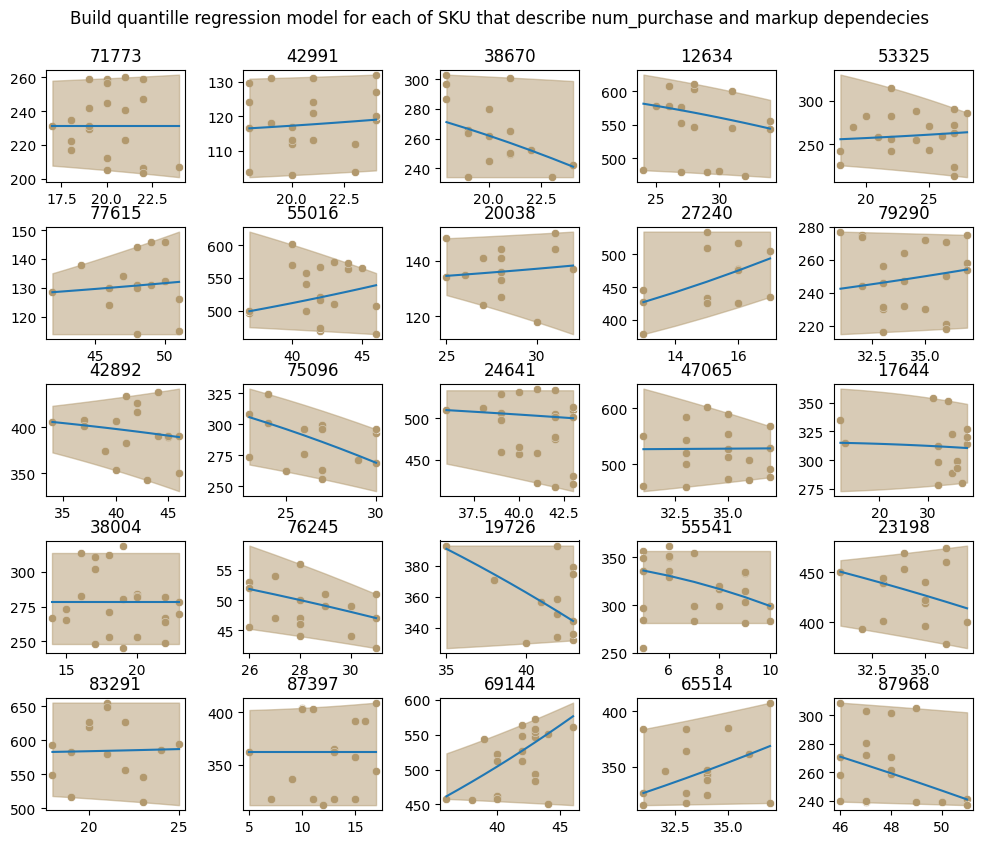

25 50


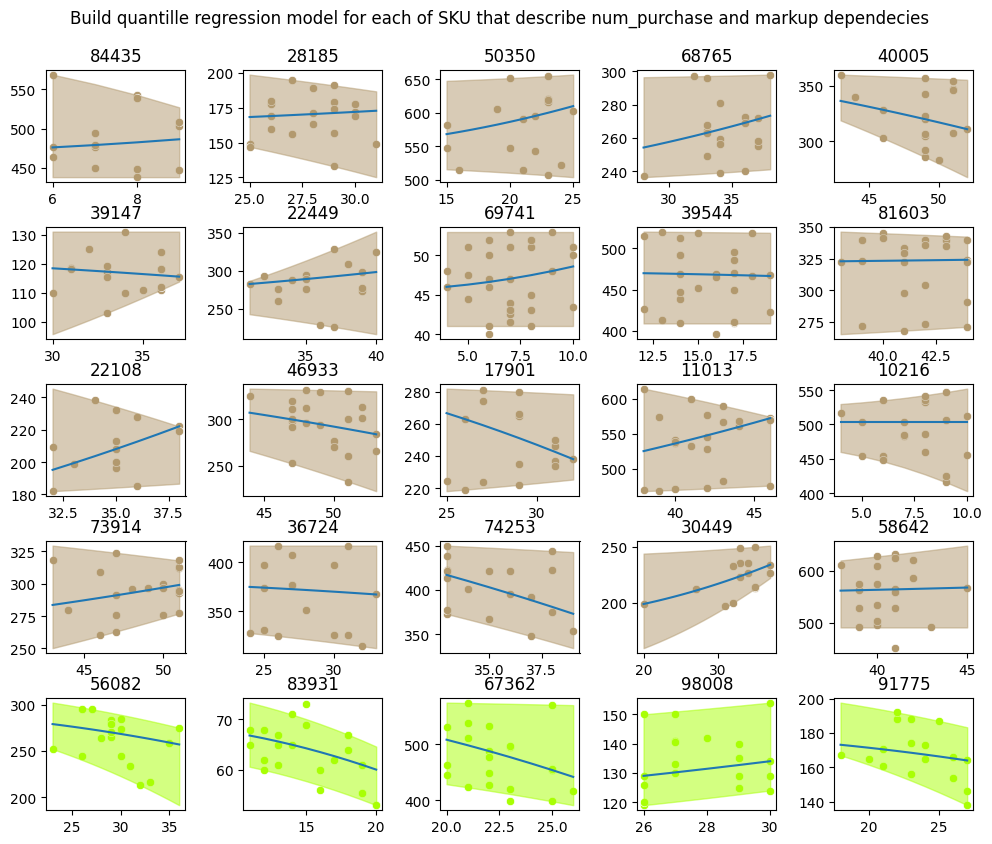

50 75


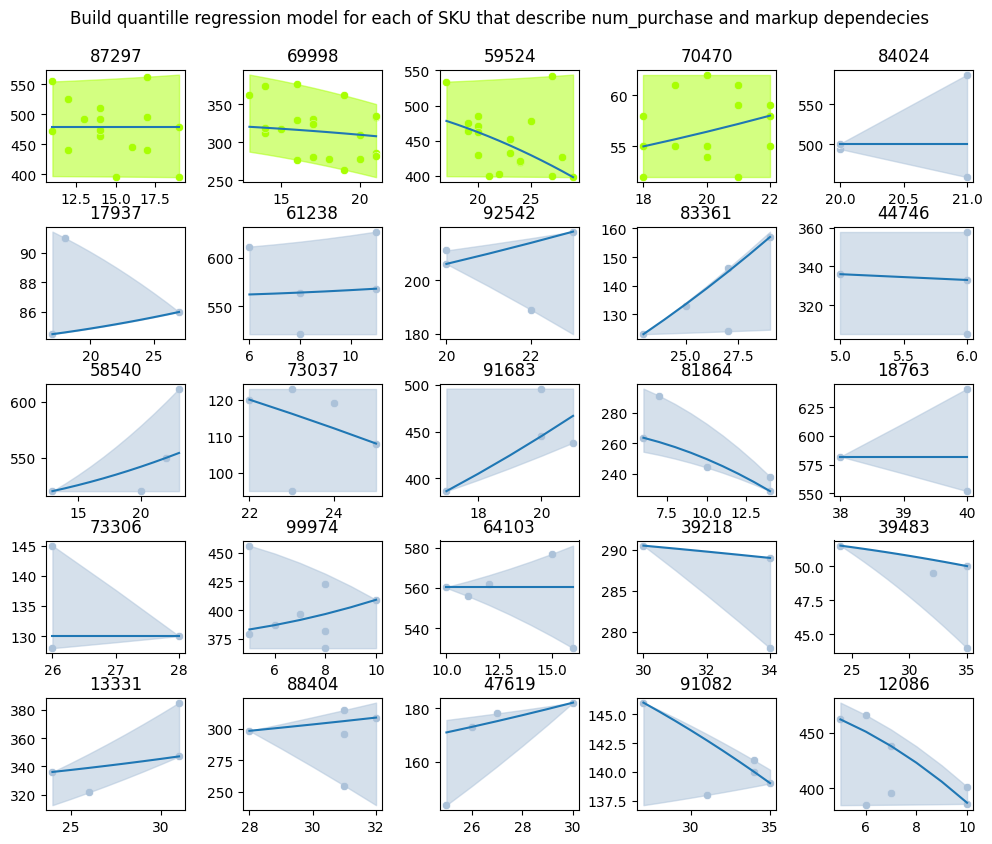

75 100


KeyboardInterrupt: 

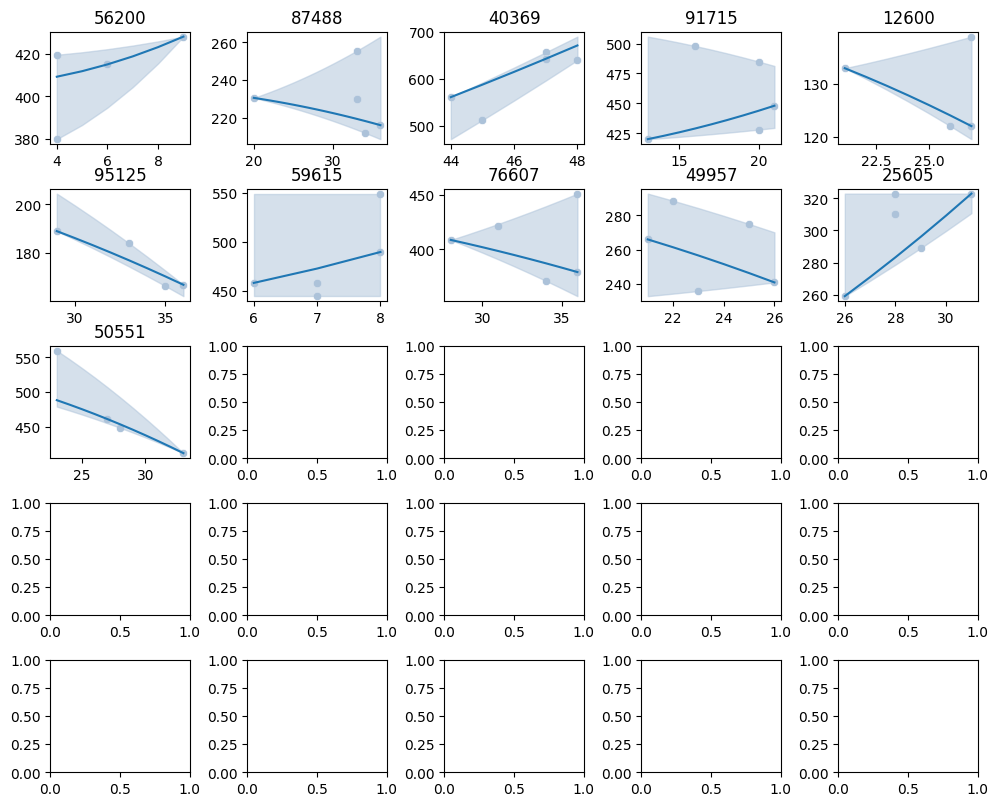

In [ ]:
# sku_group - from "clustering" chapter
get_group = lambda x: x['sku_group'].max()

regressions = {}
# plot scatter and regression model for each SKU
# split all SKUs on subsamples to build plot
start, end = 0, 0
step = 25

metric = 'markup' # price_per_sku

while end < N_sku:
  end = start + step
  print(start, end)
  group = list(purchase.sort_values(['sku_group'])['SKU'].unique())[start:end]
  COLUMNS = 5
  ROWS = int(np.ceil(len(group) / COLUMNS))
  fig, axs = plt.subplots(ROWS,COLUMNS, figsize = (10,8))
  fig.tight_layout()
  axs = axs.flatten()

  for index, SKU in enumerate(group):
    df_plot = purchase.query("SKU.isin([@SKU])")
    sns.scatterplot(data = df_plot, x = 'num_purchase', y = metric, color = palette[get_group(df_plot)], ax = axs[index])

    regress = build_regression(purchase, 'num_purchase', metric, SKU, quantiles = QUANTILE)
    regressions[SKU] = regress
    x, y = use_regression(df_plot['num_purchase'].min(),
                          df_plot['num_purchase'].max(),
                          regress)

    # sns.lineplot(x = x, y = y, ax = axs[index])
    COLUMNS = list(y.keys())
    sns.lineplot(x = x, y = y[COLUMNS[len(COLUMNS)//2]], ax = axs[index])
    axs[index].fill_between(x, y1 = y[COLUMNS[0] ], y2 = y[COLUMNS[-1]], alpha = 0.5, color = palette[get_group(df_plot)])

    axs[index].set_ylabel('')
    axs[index].set_xlabel('')
    axs[index].set_title(SKU)

  plt.suptitle(f"Build quantile regression model for each of SKU that describe num_purchase and {metric} dependecies", y=1.05)
  plt.show()
  start = end

In [ ]:
import pickle
#save regressors for each SKU
# PATH = DIR + 'num_purchase_price_regressions.pickle'
PATH = DIR + 'num_purchase_margin_regressions.pickle'

# with open(PATH, 'wb') as handle:
#     pickle.dump(regressions, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH, 'rb') as handle:
    regressions = pickle.load(handle)

## num_purchase prediction

In [ ]:
GB = ['SKU', 'year_week']
purchase = (pd.read_csv(DIR + TRANSACTIONS,  skiprows= lambda i: i>0 and random.random() > 1)
              .assign(dates = lambda x: pd.to_datetime(x['dates']))
              .assign(year = lambda x: x['dates'].dt.year)
              .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
              .assign(year_week = lambda x: x['dates'].dt.strftime("%Y-%W")  )
              # aggregate num_purchase by week
              .groupby(GB)
              .agg(num_purchase =('price','count'),
                    price_per_sku = ('price','mean'))
              .reset_index()
              .sort_values(GB)
              # set first/last week marker,
              .merge(placement, on = ['SKU', 'year_week'], how = 'left')
              .assign(first_week = 1)
              .assign(first_week = lambda x: x.sort_values(['SKU','year_week'], ascending=True)
                                              .groupby('SKU')['first_week'].cumsum())
              .assign(last_week = 1)
              .assign(last_week = lambda x: x.sort_values(['SKU','year_week'], ascending=False)
                                              .groupby('SKU')['last_week'].cumsum())

              .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
              .merge(clusters, on = 'SKU', how = 'left')
)
# remove outliers
quantile = (purchase.groupby('SKU').apply(lambda group: pd.Series({
                                                        'q_05' : np.quantile(group['num_purchase'], 0.05),
                                                        'q_95' : np.quantile(group['num_purchase'], 0.95),
                                                        'cnt' : group.shape[0],
                                                        }), include_groups=False))
purchase = (purchase.merge(quantile, on = 'SKU', how = 'left')
                    .query("(num_purchase > q_05) & (num_purchase < q_95) | (cnt < 10)")
                    .query("placement_date.isna() & (first_week > 1) & (last_week > 1)"))


purchase = purchase
SKUs = purchase['SKU'].unique()

In [ ]:
purchase = (purchase.sort_values(['SKU', 'year_week'])
                    # train/test split
                    .assign(rank = lambda group: group.groupby('SKU')['year_week'].transform(lambda x: range(1, len(x) + 1)))
                    .assign(len = lambda group: group.groupby('SKU')['year_week'].transform('count'))
                    .assign(rank = lambda group: group['rank'] / group['len'])
                    .assign(train_split = lambda x: np.where(x['rank'] < 0.8, 'train', 'test'))
                    # normilize num_purchase
                    .assign(num_purchase_max = lambda group: group.query("train_split == 'train'").groupby('SKU')['num_purchase'].transform('max'))
                    .assign(num_purchase_min = lambda group: group.query("train_split == 'train'").groupby('SKU')['num_purchase'].transform('min'))
                    .assign(num_purchases_norm = lambda group: group.groupby('SKU').apply(
                                                                         lambda x: (x['num_purchase'] - min(x['num_purchase_min']))
                                                                                 / (max(x['num_purchase_max']) - min(x['num_purchase_min']))).reset_index(drop = True))
                    # .assign(num_purchases_norm = lambda group: group.groupby('SKU').apply(lambda x: normilizer(x['num_purchase'])))
)

<ipython-input-16-da3d65965468>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .assign(num_purchases_norm = lambda group: group.groupby('SKU').apply(


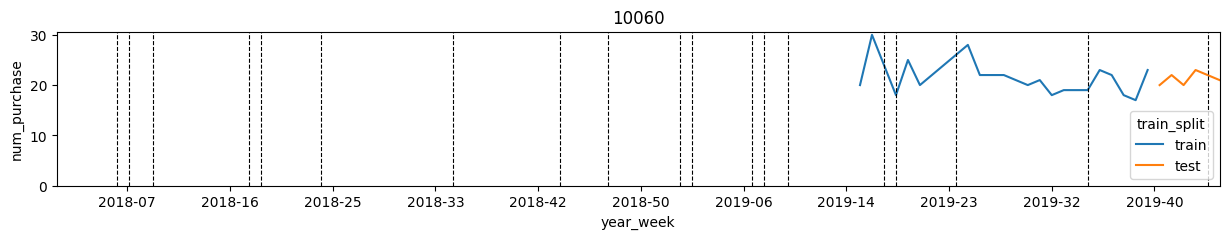

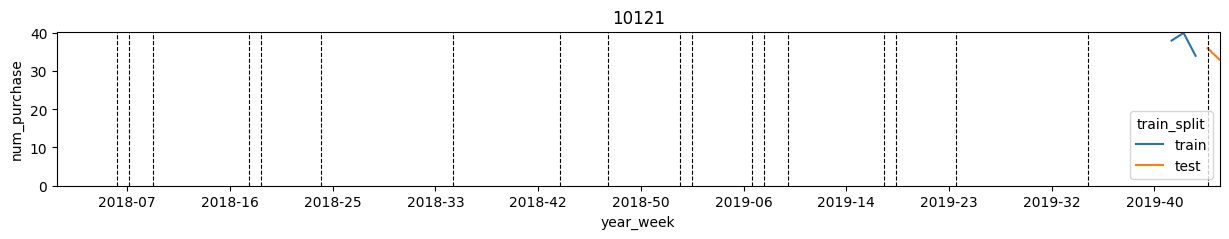

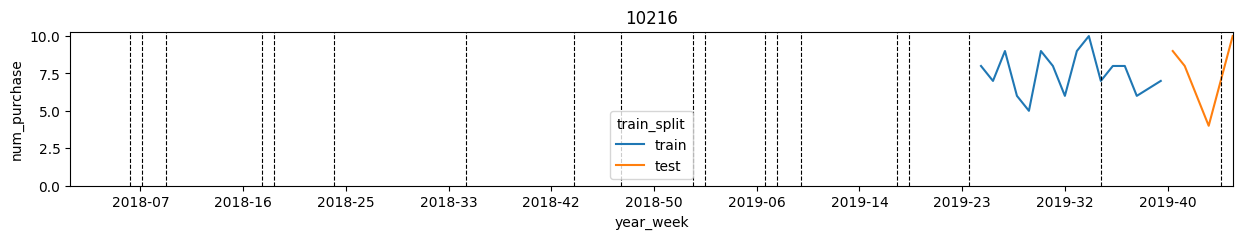

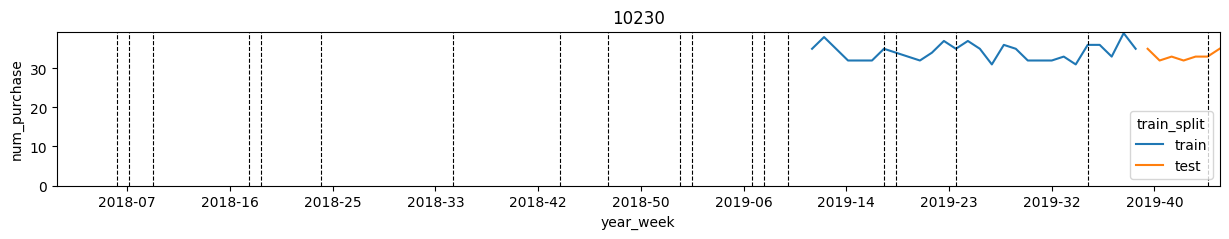

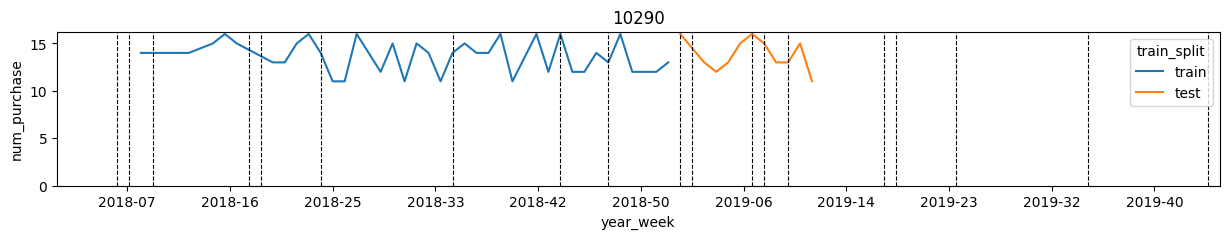

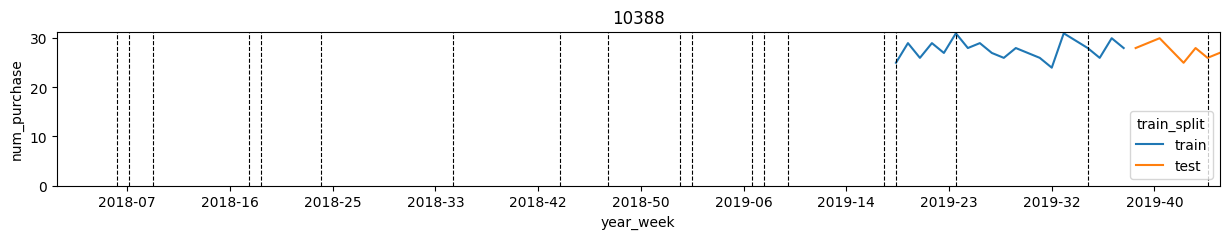

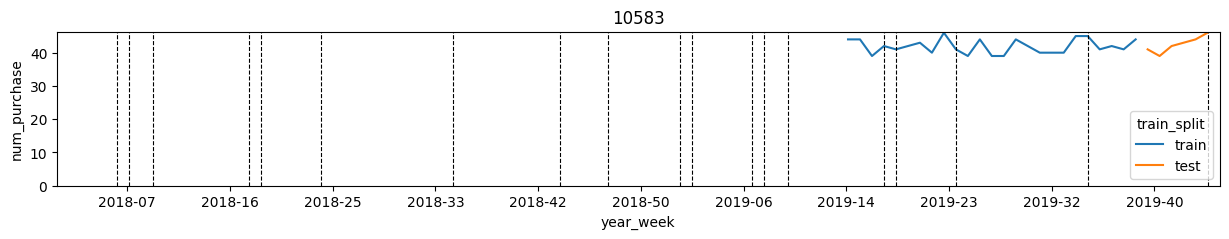

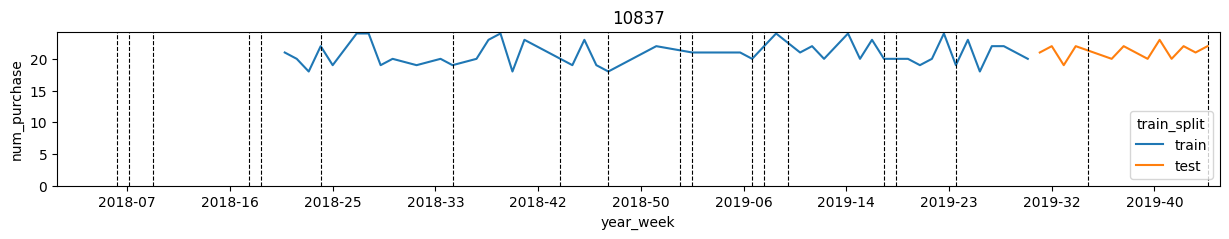

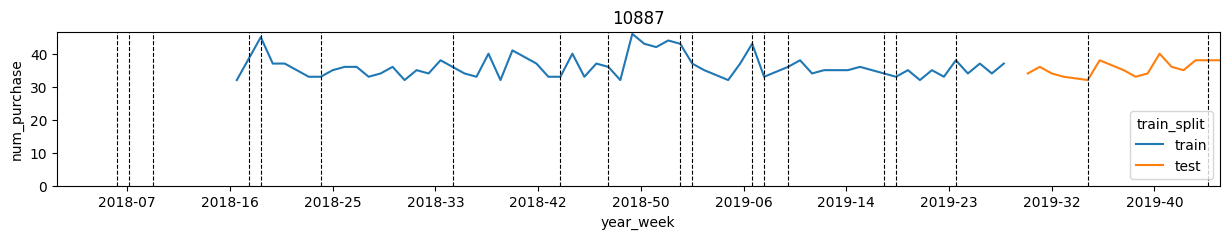

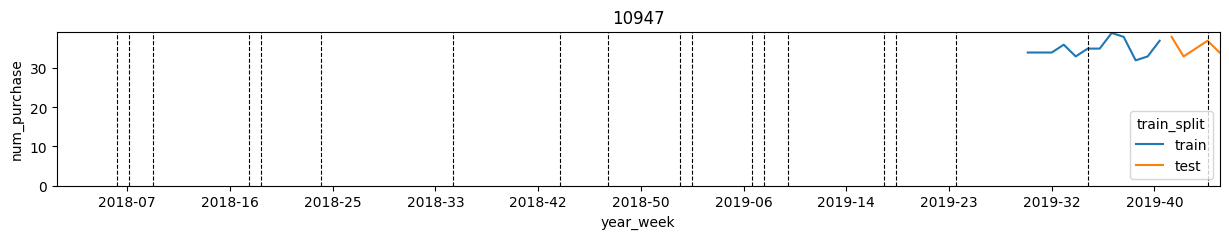

In [ ]:
SKU = SKUs[0]
start_date = purchase['year_week'].min()
end_date = purchase['year_week'].max()
start_date, end_date

for SKU in SKUs[:10]:
  fig, ax = plt.subplots(figsize = (15, 2))
  ax.set_xlim(start_date, end_date)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))
  ax = sns.lineplot(data = purchase.query("SKU == @SKU"), x = 'year_week', y = 'num_purchase', ax = ax, hue = 'train_split')
  # ax2 = ax.twinx()
  # sns.lineplot(data = purchase.query("SKU == @SKU"), x = 'year_week', y = 'num_purchase', ax = ax2, hue = 'train_split')
  xlim = ax.get_xlim()
  for i in df_holidays['year_week'].to_list():
      ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
  ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
  ax.set_xlim(xlim)
  ax.set_ylim(0)
  plt.title(SKU)
  plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot
# plot autocorrelation and get optimal lag assumption
get_group = lambda x: x['sku_group'].max()

df_plot = (purchase.sort_values(['sku_group', 'SKU','year_week'])
)
SKU_lag = {}
# split all SKUs on subsamples to build plot
start, end = 0, 0
step = 25

while end < N_sku:
  end = start + step
  print(start, end)
  group = list(purchase.sort_values(['sku_group'])['SKU'].unique())[start:end]
  COLUMNS = 5
  ROWS = int(np.ceil(len(group) / COLUMNS))
  fig, axs = plt.subplots(ROWS, COLUMNS, figsize = (10,10))
  fig.tight_layout()

  axs = axs.flatten()

  for index, SKU in enumerate(group):
    _ = df_plot.query("SKU.isin([@SKU])")
    autocorrelation_plot(_['num_purchase'], ax = axs[index], color = palette[get_group(_)])
    axs[index].set_ylabel('')
    axs[index].set_xlabel('')
    axs[index].set_title(SKU)

    plot_data = axs[index].lines[-1].get_xydata()
    x, y = plot_data[:, 0], plot_data[:, 1]
    optimal_lag_idx = np.argmax(np.abs(y) < 0.1/np.sqrt(len(x)))

    SKU_lag[SKU] = x[optimal_lag_idx]

  display(pd.DataFrame(dict(filter(lambda i:i[0] in group, SKU_lag.items())), index=['lag']))

  plt.suptitle("Autocorrelation function of num_purchase for each SKU", y=1.05)
  plt.show()
  start = end

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pickle
#save LAG assumptions for each SKU
PATH = DIR + 'LAG_assumptions.pickle'

# with open(PATH, 'wb') as handle:
#     pickle.dump(SKU_lag, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH, 'rb') as handle:
    SKU_lag = pickle.load(handle)

#### old

In [ ]:
# remove SKU witch have less than two lag time line
too_small_data = (purchase.groupby('SKU')
                          .agg({'year_week':'count'})
                          .merge(pd.DataFrame(SKU_lag, index = ['lag']).T.rename_axis('SKU'), on = 'SKU', how = 'left')
                          .query("lag*2 >= year_week").reset_index()
)['SKU'].to_list()

NameError: name 'SKU_lag' is not defined

In [ ]:
# define LSTM model
from sklearn.preprocessing import MinMaxScaler
import torch, torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
# define class SKU_LSTM to build LSTM model for each of SKU
class SKU_LSTM():
  def __init__(self,
               raw_data,
               SKU,
               SKU_lag_assumptions = 5,
               epochs = 150,
               lr=0.001,
               value = 'num_purchase',
               ):

    self.SKU = SKU
    self.value = value
    self.df_train = raw_data.query("SKU.isin([@SKU])")
    self.scaler = MinMaxScaler(feature_range=(-1, 1))
    self.train_data_norm = self.scale_transform(self.df_train)

    self.train_window = int(SKU_lag_assumptions) # try to get more wide window
    self.train_inout_seq = self.create_inout_sequences(self.train_data_norm, self.train_window)
    self.epochs = epochs

    self.model = LSTM()
    self.loss_function = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr = lr)

  # scaling and casting to tourch tensor
  def scale_transform(self, df):
    _ = self.scaler.fit_transform(df[self.value].to_numpy().reshape(-1,1))
    _ = torch.FloatTensor(_).view(-1)
    return _

  # prepare contitnious dates
  def prepare_forcast_dates(self, df_test):
    SKU = self.SKU
    date_from = self.df_train['dates'].max()
    date_to = (df_test.query("SKU.isin([@SKU])")
                      .assign(dates = lambda x: pd.to_datetime(x['dates']))
                      ['dates'].max())

    predicted_dates = (pd.DataFrame(pd.date_range(date_from + timedelta(days = 1) ,date_to,freq='d'), columns = ['dates'])
                         .assign(num_purchases = np.nan))
    return predicted_dates

  # The function will accept the raw input data and will return a list of tuples.
  # In each tuple, the first element will contain a list of N items corresponding to the number of num purchase in N days,
  # the second tuple element will contain one item i.e. the number of purchase in the N+1st days. N = train_window
  def create_inout_sequences(self, input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

  def fit(self):
    for i in range(self.epochs):
      for seq, labels in self.train_inout_seq:
        self.optimizer.zero_grad()
        self.model.hidden_cell = (torch.zeros(1, 1, self.model.hidden_layer_size),
                                  torch.zeros(1, 1, self.model.hidden_layer_size))
        y_pred = self.model(seq)

        single_loss = self.loss_function(y_pred, labels)
        single_loss.backward()
        self.optimizer.step()

      if i%25 == 1:
          print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return self

  def transform(self, df_predict):
    predicted_dates = df_predict #self.prepare_forcast_dates(df_predict)
    N_to_predict = predicted_dates.shape[0]
    test_inputs = self.train_data_norm[-self.train_window:].tolist()

    for i in range(N_to_predict):
      seq = torch.FloatTensor(test_inputs[-self.train_window:])
      with torch.no_grad():
          self.model.hidden = (torch.zeros(1, 1, self.model.hidden_layer_size),
                               torch.zeros(1, 1, self.model.hidden_layer_size))
          test_inputs.append(self.model(seq).item())

    actual_predictions = self.scaler.inverse_transform(np.array(test_inputs[self.train_window:] ).reshape(-1, 1))
    predicted_dates = (predicted_dates.assign(SKU = self.SKU)
                                      .assign(predict = np.ceil(actual_predictions)))
    return predicted_dates

In [ ]:
# build models
models = {}
predictions = {}
group = list(purchase.query("~SKU.isin(@too_small_data)")['SKU'].unique())

for SKU in group:
  print(SKU)
  curr_model = SKU_LSTM(purchase.query("train_split == 'train'"), SKU, SKU_lag[SKU], epochs = 100).fit()
  curr_predict = curr_model.transform(purchase.query("train_split == 'test'").query("SKU.isin([@SKU])"))
  predictions[SKU] = curr_predict
  models[SKU] = curr_model

In [ ]:
import pickle
# save LSTM model
PATH = DIR + 'SKU_LSTM.pickle'
# with open(PATH, 'wb') as handle:
#     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH, 'rb') as handle:
    models = pickle.load(handle)

In [ ]:
SKUs =  purchase['SKU'].unique()
len(SKUs), len(models), len(regressions)

(1000, 988, 1000)

In [ ]:
def num_purchase_to_price(SKU, x) -> np.ndarray:
  # calculate margin based on regression dependencies
  global regressions
  global transform
  X = x.to_numpy().reshape(-1,1)
  X = transform(np.abs(X))

  result = np.abs(regressions[SKU].predict(X))
  return result

# predict December
date_from = datetime(2019,12,1)
date_to = datetime(2019,12,31)

# yaer_week all permutations
base = (pd.DataFrame({'year_week': pd.date_range(date_from,date_to)})
          .assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
          .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
          .drop_duplicates()
)

# SKU and yaer_week all permutations
base_large = (pd.DataFrame(pd.date_range(purchase['year_week'].min(), date_to), columns = ['year_week'])
                             .assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
                             .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                             .assign(f = 1)
                             .merge(pd.DataFrame(SKUs, columns = ['SKU']).assign(f = 1), on = 'f')
                             .drop_duplicates())

# cost_price of each SKU, with all dates weeks
cost_price = (pd.read_csv(DIR + TRADES)
                .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                .groupby(['SKU', 'year_week']).agg({'cost_price':'mean'})
                .merge(base_large[['SKU', 'year_week']], on = ['SKU', 'year_week'], how = 'right')
                .assign(cost_price = lambda x: x['cost_price'].fillna(x.groupby('SKU')['cost_price'].transform('mean')))
                )

predictions = pd.DataFrame()
SKU_error = []

for SKU in SKUs:#set(SKUs) - set(predictions['SKU'].drop_duplicates().to_list()):
  # num_purchase history
  data1 = (purchase.query("SKU.isin([@SKU])")
                   .sort_values('year_week')
                   .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w")))

  # predict num_puchease or fill mean num_puchease if model is empty
  if SKU in models.keys():
    data2 = models[SKU].transform(base)
  else:
    data2 = (base.assign(SKU = SKU)
                 .assign(predict = data1['num_purchase'].mean())
            )

  # catch errors where num_purchase less than 0
  if data2['predict'].min() < 0:
    SKU_error.append(SKU)

  else:
  # calculate margine based on num_purchase use regressions
  # calculate price_per_sku as margine * num_purchase
    data2 = (data2.assign(margin_predict = lambda x: num_purchase_to_price(SKU, x['predict']))
                  .merge(cost_price, on = ['SKU', 'year_week'], how = 'left')
                  .assign(price_predict = lambda x: x['cost_price'] * (1 + x['margin_predict']))
            )
    # save predictions
    predictions = pd.concat([data2, predictions])
    # plot history and predictions
    fig, ax = plt.subplots(figsize = (12, 2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))

    sns.lineplot(data = data1, x = 'year_week', y = 'price_per_sku', ax = ax)
    sns.lineplot(data = data2, x = 'year_week', y = 'price_predict', ax = ax)

    for i in df_holidays['year_week'].to_list():
        ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(12)),  plt.title(SKU)
    plt.show()

print(SKU_error)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predictions.to_parquet(DIR + 'predictions_margine_lstm.parquet')

In [ ]:
# for SKU in SKU_error:
#   print(SKU)
#   curr_model = SKU_LSTM(purchase.query("train_split == 'train'"), SKU, 10, epochs = 100).fit()
#   curr_predict = curr_model.transform(purchase.query("train_split == 'test'").query("SKU.isin([@SKU])"))
#   models[SKU] = curr_model

# import pickle
# # save LSTM model
# PATH = DIR + 'SKU_LSTM.pickle'
# with open(PATH, 'wb') as handle:
#     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PATH, 'rb') as handle:
#     models = pickle.load(handle)

86515
epoch:   1 loss: 0.22170050
epoch:  26 loss: 0.04733834
epoch:  51 loss: 0.02282595
epoch:  76 loss: 0.00985891
epoch:  99 loss: 0.0011011219


## quantile LSTM train

In [ ]:
# models = {}
IOUs = {} # intersection over union metric

for SKU in SKUs:#list(set(SKUs) - set(models.keys())):
  train = purchase.query("train_split == 'train'").query("SKU.isin([@SKU])")
  test = purchase.query("train_split == 'test'").query("SKU.isin([@SKU])")

  # pass to small data
  if train.shape[0] < 3:
        continue

  curr_model = SKU_LSTM_quantille(train, SKU, min(SKU_lag[SKU], train.shape[0] // 2), epochs = 100, quantiles = QUANTILE ).fit()
  curr_predict = curr_model.transform(test).assign(year_week = test['year_week'].to_list())
  models[SKU] = curr_model

  data2 = (curr_predict.assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
                      .merge(cost_price, on = ['SKU', 'year_week'], how = 'left')
                      .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w")))

  COLUMNS = curr_model.COLUMNS
  median_predict = COLUMNS[len(COLUMNS)//2]
  std_price = np.sqrt(train['num_purchase'].std())

  for c in COLUMNS:
      data2 = data2.assign(**{'markup_' + c: lambda x : num_purchase_to_price_quantille(SKU, x[c], c)})
      data2 = data2.assign(**{'price_' + c: lambda x: x['cost_price']  + x['markup_' + c]})

  data1 = train.assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W")).assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))

  fig, axes = plt.subplots(1,3, figsize = (19, 2), width_ratios=[3,3, 1])
  axes = axes.flatten()
  # plot num_purchase prediction
  ax = axes[0]
  sns.lineplot(data = data1, x = 'year_week', y = 'num_purchase', ax = ax, label = 'train')

  sns.lineplot(data = data2, x = 'year_week', y = median_predict, ax = ax, label = median_predict, color = 'tab:green')
  ax.fill_between(data = data2, x = 'year_week', y1 = COLUMNS[0], y2 = COLUMNS[-1], alpha = 0.5, color = 'tab:green')

  sns.lineplot(data = test, x = 'year_week', y = 'num_purchase', ax = ax, label = 'test', linestyle = '--')
  ax.fill_between( x = test['year_week'], y1 = test['num_purchase'] - std_price, y2 = test['num_purchase'] + std_price, alpha = 0.5, color = 'tab:orange')
  # plot price prediction
  ax = axes[1]
  sns.lineplot(data = data1, x = 'year_week', y = 'price_per_sku', ax = ax)

  sns.lineplot(data = data2, x = 'year_week', y = 'price_' + median_predict, ax = ax, label = median_predict, color = 'tab:green')
  ax.fill_between(data = data2, x = 'year_week', y1 = 'price_' + COLUMNS[0], y2 = 'price_' + COLUMNS[-1], alpha = 0.5, color = 'tab:green')

  sns.lineplot(data = test, x = 'year_week', y = 'price_per_sku', ax = ax, label = 'test', linestyle = '--', color = 'tab:orange')
  sns.lineplot(data = data2, x = 'year_week', y = 'cost_price', ax = ax, label = 'cost_price', color = 'tab:red')
  # plot num_purchase price per SKU dependencies
  ax = axes[2]
  x, y = use_regression(data1['num_purchase'].min(),
                        data1['num_purchase'].max(),
                        regressions[SKU])
  sns.lineplot(x = x, y = y[COLUMNS[len(COLUMNS)//2]], ax = ax), ax.set_ylabel('markup'), ax.set_xlabel('num_purchase')
  ax.fill_between(x, y1 = y[COLUMNS[0] ], y2 = y[COLUMNS[-1]], alpha = 0.5)

  # plot holydays
  for ax in axes[:2]:
    for i in df_holidays['year_week'].to_list():
        ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6)),  plt.suptitle(SKU)
  plt.show()

  # calculate intersections over union metric for num_purchase prediction
  lower = data2[COLUMNS[0]]
  upper = data2[COLUMNS[-1]]
  target = test['num_purchase']
  std = np.sqrt(train['num_purchase'].std())
  try:
    iou_coeff = calculate_iou(lower, upper, target, std, plot_polygons = True)
  except:
    iou_coeff = 0
  IOUs[SKU] = iou_coeff
  print("Intersection over union coeff: ", round(iou_coeff, 2))

Output hidden; open in https://colab.research.google.com to view.

<Axes: ylabel='Count'>

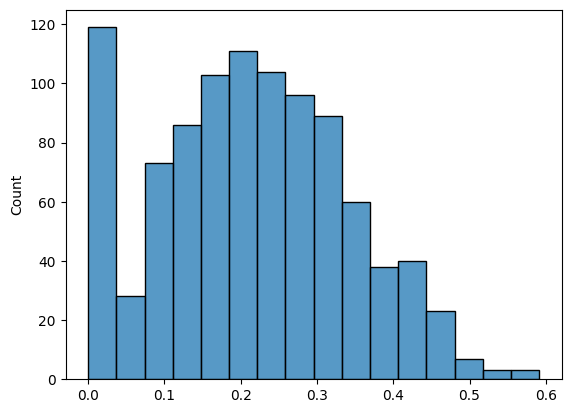

In [ ]:
# plot itersection over union coeff
sns.histplot(list(IOUs.values()))

In [ ]:
import pickle
# save quantille LSTM model
PATH = DIR + 'SKU_LSTM_quantille.pickle'
# with open(PATH, 'wb') as handle:
#     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH, 'rb') as handle:
    models = pickle.load(handle)

## quantile LSTM prediction

In [11]:
COLUMNS = ['pred_q5', 'pred_q50', 'pred_q95']
median_predict = COLUMNS[len(COLUMNS)//2]
# predict December
date_from = datetime(2019,12,1)
date_to = datetime(2019,12,31)

# yaer_week all permutations
base = (pd.DataFrame({'year_week': pd.date_range(date_from,date_to)})
          .assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
          .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
          .drop_duplicates()
)

# SKU and yaer_week all permutations
base_large = (pd.DataFrame(pd.date_range(purchase['year_week'].min(), date_to), columns = ['year_week'])
                             .assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
                             .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                             .assign(f = 1)
                             .merge(pd.DataFrame(SKUs, columns = ['SKU']).assign(f = 1), on = 'f')
                             .drop_duplicates())

# cost_price of each SKU, with all dates weeks
cost_price = (pd.read_csv(DIR + TRADES)
                .assign(year_week = lambda x: x['year'].astype(str) + '-' + x['week_num'].astype(str))
                .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                .groupby(['SKU', 'year_week']).agg({'cost_price':'mean'})
                .merge(base_large[['SKU', 'year_week']], on = ['SKU', 'year_week'], how = 'right')
                .assign(cost_price = lambda x: x['cost_price'].fillna(x.groupby('SKU')['cost_price'].transform('mean')))
                .drop_duplicates(['SKU', 'year_week'])
                )

predictions = pd.DataFrame()
SKU_error = []

for SKU in SKUs:#set(SKUs) - set(predictions['SKU'].drop_duplicates().to_list()):
  # num_purchase history
  data1 = (purchase.query("SKU.isin([@SKU])")
                   .sort_values('year_week')
                  #  .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                   )

  # predict num_puchease or fill mean num_puchease if model is empty
  if SKU in models.keys():
    data2 = models[SKU].transform(base)
    data2 = (pd.concat([base.reset_index(drop = True), data2.reset_index(drop = True)], axis = 1))
  else:
    std = data1['num_purchase'].std()
    data2 = (base.assign(SKU = SKU)
                 .assign(**{COLUMNS[0]: data1['num_purchase'].mean() - np.sqrt(std)})
                 .assign(**{median_predict: data1['num_purchase'].mean()})
                 .assign(**{COLUMNS[-1]: data1['num_purchase'].mean() + np.sqrt(std)})
            )

  # catch errors where num_purchase less than 0
  if data2[COLUMNS].min( axis = 1).min() < 0:
    SKU_error.append(SKU)

  else:
  # calculate margin based on num_purchase use regressions
  # calculate price_per_sku as margine * num_purchase
    data2 = (data2
               .merge(cost_price, on = ['SKU', 'year_week'], how = 'left'))
    for c in COLUMNS:
        data2 = data2.assign(**{'markup_' + c: lambda x : num_purchase_to_price_quantille(SKU, x[c], c)})
        data2 = data2.assign(**{'price_' + c: lambda x: x['cost_price']  + x['markup_' + c]})

    # save predictions
    predictions = pd.concat([data2, predictions])
    # plot history and predictions
    fig, ax = plt.subplots(figsize = (12, 2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))

    sns.lineplot(data = data1, x = 'year_week', y = 'price_per_sku', ax = ax)

    sns.lineplot(data = data2, x = 'year_week', y = 'price_' + median_predict, ax = ax, label = median_predict, color = 'tab:green')
    ax.fill_between(data = data2, x = 'year_week', y1 = 'price_' + COLUMNS[0], y2 = 'price_' + COLUMNS[-1], alpha = 0.5, color = 'tab:green')

    for i in df_holidays['year_week'].to_list():
        ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(12)),  plt.title(SKU)
    plt.show()

print(SKU_error)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
def start_of_week(date):
    # Calculate the start of the week (Monday) for the given date
    start = date - timedelta(days=date.weekday())
    return start

SKUs_remain = list(set(SKUs) - set(predictions['SKU']))
COLUMNS = ['pred_q5', 'pred_q50', 'pred_q95']
median_predict = COLUMNS[len(COLUMNS)//2]

date_from = start_of_week(datetime(2019,12,1)).strftime(PANDAS_DATE_FORMAT)
date_to = start_of_week(datetime(2019,12,31)).strftime(PANDAS_DATE_FORMAT)

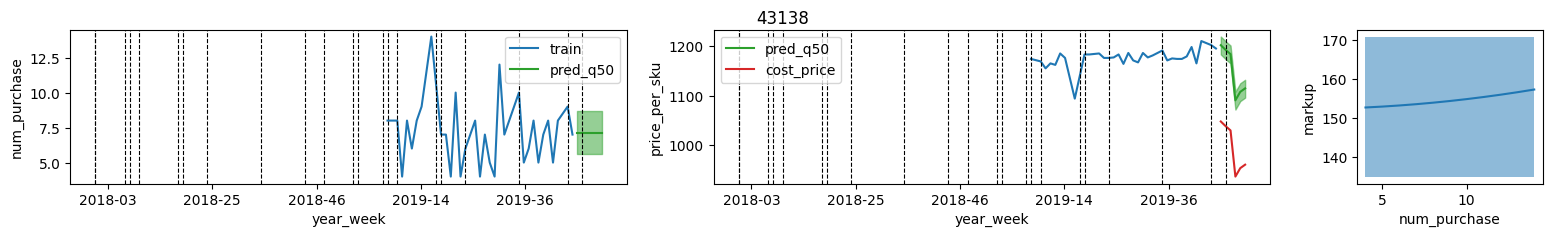

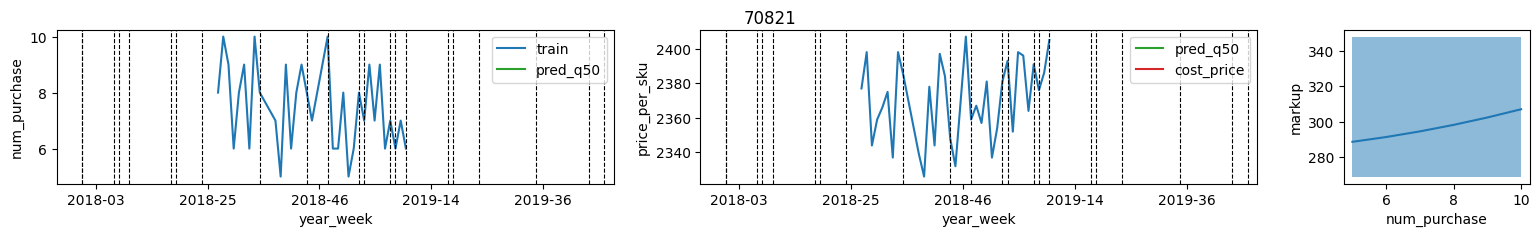

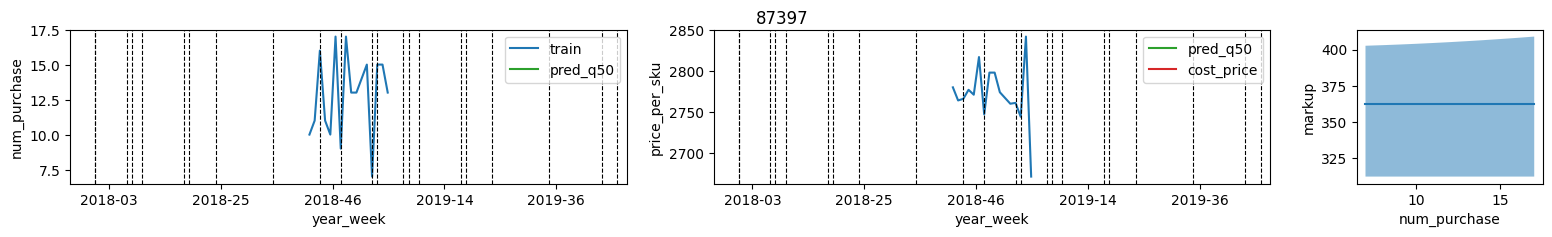

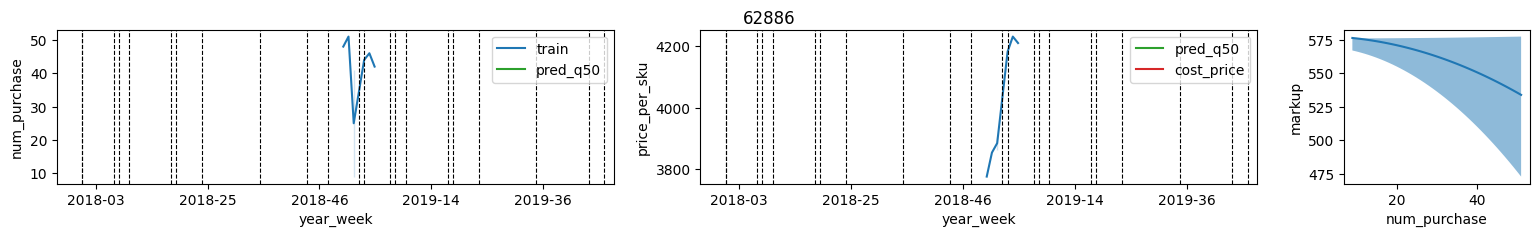

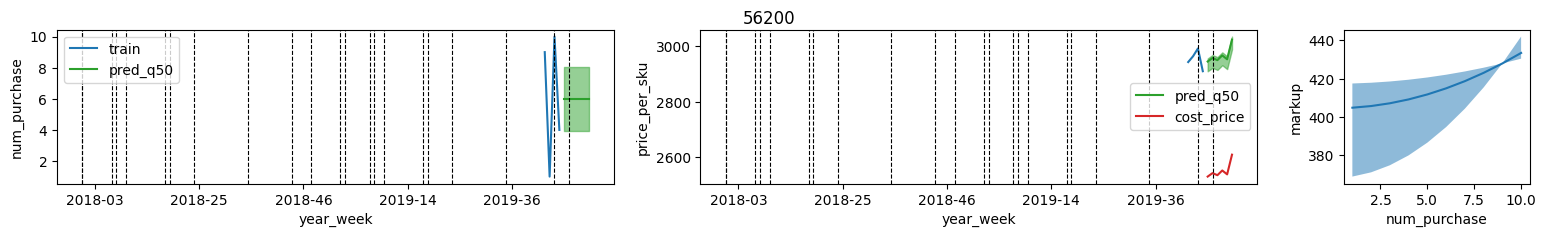

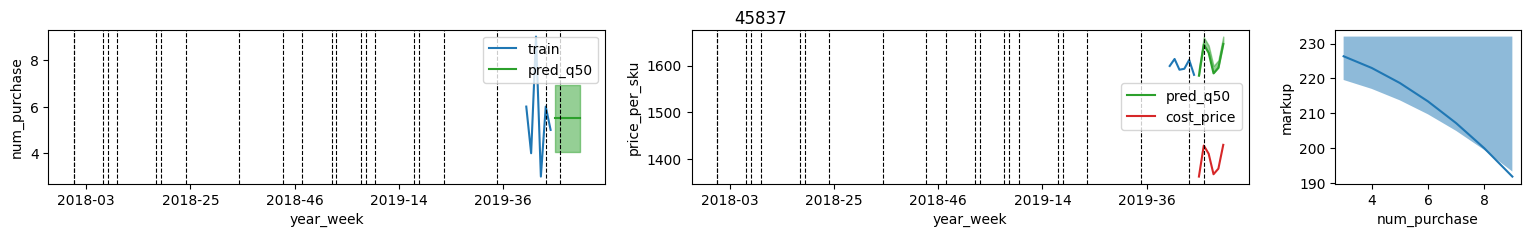

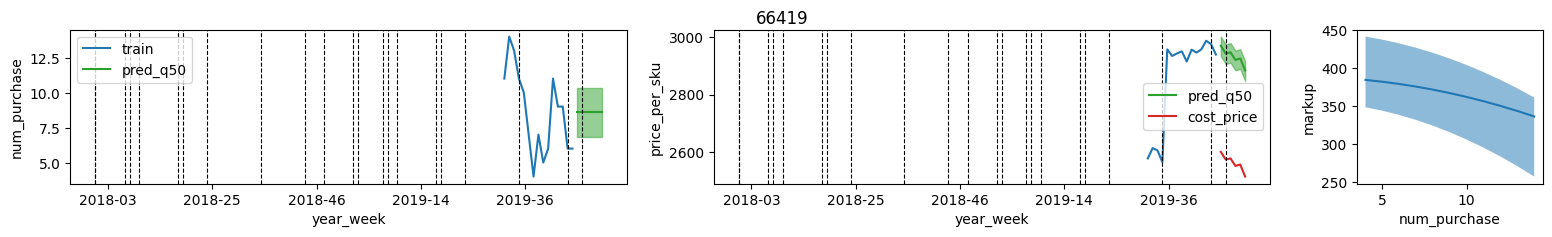

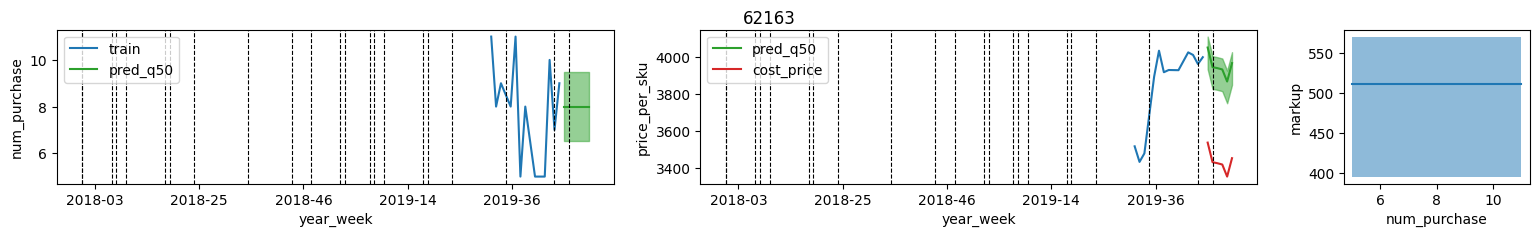

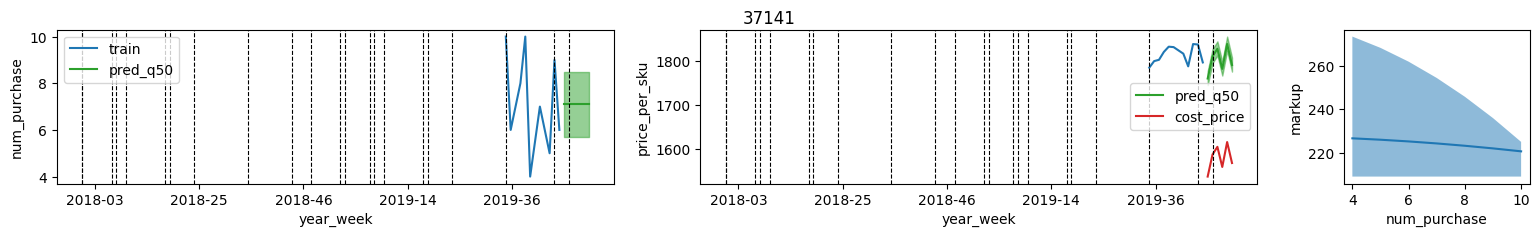

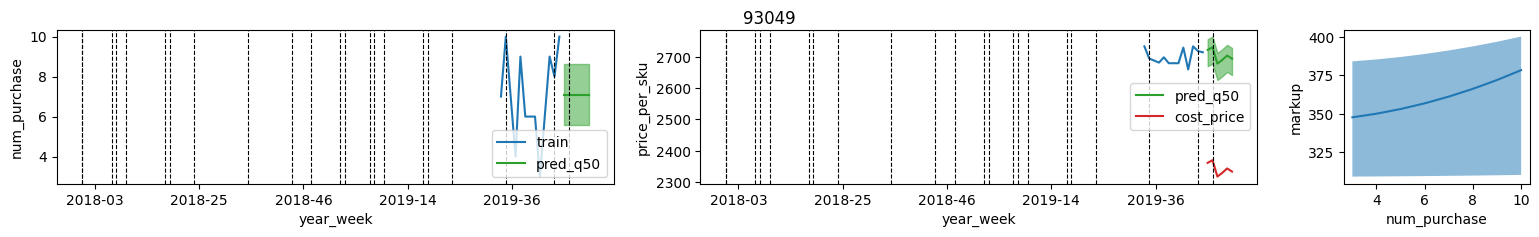

In [20]:
# suggest for erros SKUs as mean previous num_purchases
predictions_remain = (purchase.query("SKU.isin(@SKUs_remain)")
                              .groupby('SKU')
                              .agg(num_purchase = ('num_purchase', 'mean'),
                                   num_purchase_std = ('num_purchase', 'std'))
                              .reset_index()
                              .merge(cost_price.query("SKU.isin(@SKUs_remain)")
                                               .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
                                               .query("year_week.between(@date_from, @date_to)"), on = ['SKU'], how = 'left')
                              .assign(**{COLUMNS[0]: lambda x: x['num_purchase'] - np.sqrt(x['num_purchase_std'])})
                              .assign(**{median_predict: lambda x: x['num_purchase']})
                              .assign(**{COLUMNS[-1]: lambda x: x['num_purchase'] + np.sqrt(x['num_purchase_std'])})
                              )

predictions_remain_result = pd.DataFrame()

for SKU in SKUs_remain:
  data1 = purchase.query("SKU.isin([@SKU])")
  data2 = predictions_remain.query("SKU.isin([@SKU])")

  for c in COLUMNS:
    data2 = data2.assign(**{'markup_' + c: lambda x : num_purchase_to_price_quantille(SKU, x[c], c)})
    data2 = data2.assign(**{'price_' + c: lambda x: x['cost_price']  + x['markup_' + c]})

  predictions_remain_result = pd.concat([data2, predictions_remain_result])

  fig, axes = plt.subplots(1,3, figsize = (19, 2), width_ratios=[3,3, 1])
  axes = axes.flatten()
  # plot num_purchase prediction
  ax = axes[0]
  sns.lineplot(data = data1, x = 'year_week', y = 'num_purchase', ax = ax, label = 'train')

  sns.lineplot(data = data2, x = 'year_week', y = median_predict, ax = ax, label = median_predict, color = 'tab:green')
  ax.fill_between(data = data2, x = 'year_week', y1 = COLUMNS[0], y2 = COLUMNS[-1], alpha = 0.5, color = 'tab:green')

  # plot price prediction
  ax = axes[1]
  sns.lineplot(data = data1, x = 'year_week', y = 'price_per_sku', ax = ax)

  sns.lineplot(data = data2, x = 'year_week', y = 'price_' + median_predict, ax = ax, label = median_predict, color = 'tab:green')
  ax.fill_between(data = data2, x = 'year_week', y1 = 'price_' + COLUMNS[0], y2 = 'price_' + COLUMNS[-1], alpha = 0.5, color = 'tab:green')

  sns.lineplot(data = data2, x = 'year_week', y = 'cost_price', ax = ax, label = 'cost_price', color = 'tab:red')
  # plot num_purchase price per SKU dependencies
  ax = axes[2]
  x, y = use_regression(data1['num_purchase'].min(),
                        data1['num_purchase'].max(),
                        regressions[SKU])
  sns.lineplot(x = x, y = y[COLUMNS[len(COLUMNS)//2]], ax = ax), ax.set_ylabel('markup'), ax.set_xlabel('num_purchase')
  ax.fill_between(x, y1 = y[COLUMNS[0] ], y2 = y[COLUMNS[-1]], alpha = 0.5)

  # plot holydays
  for ax in axes[:2]:
    for i in df_holidays['year_week'].to_list():
        ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6)),  plt.suptitle(SKU)
  plt.show()

In [23]:
pd.concat([predictions, predictions_remain_result]).to_parquet(DIR + 'predictions_margine_lstm_quantille.parquet')

In [25]:
pd.read_parquet(DIR + 'predictions_margine_lstm_quantille.parquet')['SKU'].nunique()

1000

#### old

In [ ]:
# define LSTM model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch, torch.nn as nn, os

# predict December
date_from = datetime(2019,12,1)
date_to = datetime(2019,12,31)

# yaer_week all permutations
base = (pd.DataFrame({'year_week': pd.date_range(date_from,date_to)})
          .assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
          .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
          .drop_duplicates()
)

def num_purchase_to_price(SKU, x) -> np.ndarray:
  # calculate margin based on regression dependencies
  global regressions
  global transform

  X = x.to_numpy().reshape(-1,1)
  X = transform(X)

  result = regressions[SKU].predict(X)

  return np.abs(result)

def num_purchase_to_price_quantille(SKU, x, c) -> np.ndarray:
  # calculate margin base on regression dependencies
  # the quantille name "c" must be the same as in regression
  global regressions
  global transform

  X = x.to_numpy().reshape(-1,1)
  X = transform(X)

  result = regressions[SKU].predict(np.abs(X))
  return np.abs(result[c])

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = torch.tensor(quantiles)

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        quantiles_minus_1 = self.quantiles - 1
        errors = target.unsqueeze(1) - preds
        losses = torch.max(quantiles_minus_1 * errors, self.quantiles * errors)
        loss = torch.mean(torch.sum(losses, dim=1))
        return loss

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1].unsqueeze(0)

seed_everything()
SKU = 10060
value = 'num_purchase'
scaler = StandardScaler()
train_window = 10
epochs = 100
quantiles = [0.25, 0.5, 0.75]

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def scale_transform(df):
    _ = scaler.fit_transform(df[value].to_numpy().reshape(-1,1))
    _ = torch.FloatTensor(_).view(-1)
    return _

# train = purchase.query("train_split == 'train'").query("SKU.isin([@SKU])")
# test = purchase.query("train_split == 'test'").query("SKU.isin([@SKU])")
train = purchase.query("SKU.isin([@SKU])")
test = base

train_norm = scale_transform(train)
train_seq = create_inout_sequences(train_norm, train_window)

model = LSTM(output_size=len(quantiles))
loss_function = QuantileLoss(quantiles)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

for i in range(epochs):
  for seq, labels in train_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    y_pred = model(seq)
    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i%25 == 1:
      print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

predicted_dates = test
N_to_predict = predicted_dates.shape[0]
test_inputs = train_norm[-train_window:].tolist()
result = torch.empty(N_to_predict, len(quantiles))


def shift_tensor(tensor, new_value):
    tensor = torch.cat((tensor[1:], torch.tensor([new_value])))
    return tensor

seq = torch.FloatTensor(test_inputs[-train_window:])
for i in range(N_to_predict):

  with torch.no_grad():
      model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

      result[i] = model(seq)
      seq = shift_tensor(seq, result[i][len(quantiles)//2])

COLUMNS = ['pred_q' + str(int(i*100)) for i in quantiles]

actual_predictions = scaler.inverse_transform(result)
predicted_dates = (pd.DataFrame(actual_predictions, columns = COLUMNS)
                     .assign(SKU = SKU)
                     .assign(year_week = test['year_week'].to_list())
                     )

curr_predict = predicted_dates
data2 = (curr_predict.assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W"))
                    .merge(cost_price, on = ['SKU', 'year_week'], how = 'left')
                    .assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))
)

for c in COLUMNS:
    # data2 = data2.assign(**{'margine_' + c: lambda x : num_purchase_to_price(SKU, x[c])})
    # data2 = data2.assign(**{'price_' + c: lambda x: x['cost_price'] * (1 + x['margine_' + c])})
    data2 = data2.assign(**{'markup_' + c: lambda x : num_purchase_to_price_quantille(SKU, x[c], c)})
    data2 = data2.assign(**{'price_' + c: lambda x: x['cost_price']  + x['markup_' + c]})

data1 = train.assign(year_week = lambda x: x['year_week'].dt.strftime("%Y-%W")).assign(year_week = lambda x: pd.to_datetime(x['year_week'] + '-1', format="%Y-%W-%w"))

fig, axes = plt.subplots(1,2, figsize = (15, 2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))
axes = axes.flatten()

ax = axes[0]
sns.lineplot(data = data1, x = 'year_week', y = 'num_purchase', ax = ax)
for c in COLUMNS:
  sns.lineplot(data = data2, x = 'year_week', y = c, ax = ax, label = c)

ax = axes[1]
sns.lineplot(data = data1, x = 'year_week', y = 'price_per_sku', ax = ax)
for c in COLUMNS:
  sns.lineplot(data = data2, x = 'year_week', y = 'price_' + c, ax = ax, label = c)

for ax in axes:
  for i in df_holidays['year_week'].to_list():
      ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
  ax.xaxis.set_major_locator(ticker.MaxNLocator(6)),  plt.suptitle(SKU)
plt.show()

In [ ]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []


        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(
                torch.max(
                   (q-1) * errors,
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

class QuantileLoss_(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = torch.tensor(quantiles)

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        quantiles_minus_1 = self.quantiles - 1
        errors = target.unsqueeze(1) - preds
        losses = torch.max(quantiles_minus_1 * errors, self.quantiles * errors)
        print(torch.sum(losses, dim=1))
        loss = torch.mean(
            torch.sum(losses, dim=1))
        return loss
print(QuantileLoss([0.25, 0.5, 0.75]).forward(torch.tensor([[1,8,3]]), torch.tensor([2])))
print(QuantileLoss_([0.25, 0.5, 0.75]).forward(torch.tensor([[1,8,3]]), torch.tensor([2])))

SKU  year_week  num_purchase  price_per_sku placement_date  first_week  \
0  10060 2019-10-14            20         2801.0            NaN          28   
1  10060 2019-10-21            22         2811.0            NaN          29   
2  10060 2019-10-28            20         2801.0            NaN          30   
3  10060 2019-11-04            23         2776.0            NaN          31   
4  10060 2019-11-11            22         2808.0            NaN          32   
5  10060 2019-11-18            21         2812.0            NaN          33   

   last_week sku_group   q_05  q_95  ...      rank  len  train_split  \
0          7     200_0  16.65  30.7  ...  0.821429   28         test   
1          6     200_0  16.65  30.7  ...  0.857143   28         test   
2          5     200_0  16.65  30.7  ...  0.892857   28         test   
3          4     200_0  16.65  30.7  ...  0.928571   28         test   
4          3     200_0  16.65  30.7  ...  0.964286   28         test   
5          2     200_0  16.65  30.7  ...  1.000000   28         test   

  num_purchase_max  num_purchase_min  num_purchases_norm  predict  \
0              NaN               NaN            0.307692     21.0   
1              NaN               NaN            0.666667     21.0   
2              NaN               NaN            1.000000     21.0   
3              NaN               NaN            0.000000     21.0   
4              NaN               NaN            0.333333     21.0   
5              NaN               NaN           -0.166667     21.0   

   margin_predict  cost_price  price_predict  
0        0.147161      2437.0    2795.632028  
1        0.147161      2457.0    2818.575254  
2        0.147161      2444.0    2803.662157  
3        0.147161      2404.5    2758.349287  
4        0.147161      2414.0    2769.247319  
5        0.147161      2400.0    2753.187061  

[6 rows x 21 columns]

## Prophet Model attempt. Try use covariates

In [ ]:
GB = ['SKU', 'dates']
df = (pd.read_csv(DIR + TRANSACTIONS,  skiprows= lambda i: i>0 and random.random() > 0.1)
   .groupby(GB)
   .agg({'price':'mean'})
   .reset_index()
   .sort_values(GB)
   .assign(dates = lambda x: pd.to_datetime(x['dates']))
   .assign(year = lambda x: x['dates'].dt.year)
   .assign(week_num = lambda x: x['dates'].dt.isocalendar().week)
   .merge(pd.read_csv(DIR + TRADES).drop_duplicates(['SKU', 'year', 'week_num']), on = ['SKU', 'year', 'week_num'], how = 'left')
   .assign(markup_coeff = lambda x: (x['price'] / x['cost_price']).round(2))
   .merge(pd.read_csv(DIR + SAMPLE_SKU).drop_duplicates(['sku_id']).rename(columns = {'sku_id':'SKU'})[['SKU', 'fincode']], on = 'SKU', how = 'left')
)
SKUs = df['SKU'].drop_duplicates().to_list()

In [ ]:
SKUs = df.groupby("SKU").agg(cnt = ('dates', 'count')).reset_index().query("cnt > 30")['SKU'].drop_duplicates().to_list()

**Prophet**

In [ ]:
def resample_interpolate(df, date_column = 'dates', value_columns = ['price', 'cost_price', 'markup_coeff']):
  base = pd.DataFrame(pd.date_range(df[date_column].min(), df[date_column].max(), freq = 'D'), columns = [date_column]).assign(flag = 1)
  df = base.merge(df.assign(flag = 1), on = ['flag', date_column], how = 'left').set_index(date_column)
  df[value_columns] = df[value_columns].resample('D').interpolate(method='linear')
  df = (df.drop('flag', axis = 1)
          .reset_index())
  return df

def transform_columns(df, target, date_column = 'dates'):
  df = (df.assign(ds = lambda x: pd.to_datetime(x[date_column]))
          .assign(y = lambda x: x[target]))
  return df

def plot_custom(train, test, forecast, target, title, date_column = 'dates' ):
  plt.figure(figsize = (15,2))
  ax = sns.lineplot(data = train, x = date_column, y = target)
  sns.lineplot(data = test, x = date_column, y = target, ax = ax)
  sns.lineplot(data = forecast, x= date_column, y = target, ax = ax)

  if 'yhat_upper'  in forecast.columns and 'yhat_lower'  in forecast.columns:
    plt.fill_between(forecast['dates'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=.5)

  xlim = ax.get_xlim()
  for i in df_holidays['ds'].to_list():
    ax.axvline(x = i, ls = '--', linewidth=0.8, c ='black')
  ax.set_xlim(xlim)
  plt.title(title)
  plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet

class ProphetModel:
    def __init__(self, holidays, daily_seasonality, weekly_seasonality, yearly_seasonality):
        self.holidays = holidays
        self.daily_seasonality = daily_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.model = None

    def fit(self, X, y=None):

        self.model = Prophet(holidays = self.holidays,
                           daily_seasonality = self.daily_seasonality,
                           weekly_seasonality = self.weekly_seasonality,
                           yearly_seasonality = self.yearly_seasonality)

        self.model.add_regressor('cost_price')
        self.model.fit(X)
        return self

    def predict(self, X):
        # future = self.model.make_future_dataframe(periods=len(X))
        future = X
        forecast = self.model.predict(future)
        return forecast

def create_prophet_pipeline(df, target, df_holidays):
    """
    Creates a scikit-learn pipeline to prepare data and fit a Prophet model.
    """
    pipeline = Pipeline([
        ('resample_interpolate', FunctionTransformer(resample_interpolate, kw_args={'date_column': 'dates', 'value_columns': ['price', 'markup_coeff']})),
        ('transform_columns', FunctionTransformer(transform_columns, kw_args={'target': target,'date_column': 'dates'})),
        ('prophet_model', ProphetModel(holidays = df_holidays,
                                        daily_seasonality = False,
                                        weekly_seasonality = True,
                                        yearly_seasonality = False))
    ])
    return pipeline

target = 'price'
pipeline = create_prophet_pipeline(df, target, df_holidays)
metrics = []

for SKU in SKUs[:10]:
  _ = resample_interpolate(df.query("SKU.isin([@SKU])"), 'dates', ['price', 'markup_coeff', 'cost_price'])
  train = _.iloc[:-30]
  test = _.iloc[-30:]
  pipeline.fit(train)
  predictions = pipeline.predict(test)
  forecast = predictions.assign(dates = lambda x: x['ds']).assign(**{target : lambda x: x['yhat']})[['dates', target, 'yhat_upper', 'yhat_lower']].iloc[-30:]

  metric = MAPE(y_true = test[target], y_pred=forecast[target])
  metrics.append(metric)
  plot_custom(train, test, forecast, target, SKU)
print(np.mean(metrics))